# Assignment No. 2
<h4>Data Mining and Machine Learning  Semester 1</h4>

<span>Fatima Mohamed [H00335257]<br></span>
<span>Stephy Savier [H00211075]<br></span>
<span>Muhammad Nauman Qureshi [H00348353]<br></span>
<span>Mohammed Farhan Majid [H00364845]<br></span>

# Environment Setup

In [1]:
import sys
import sklearn
assert sklearn.__version__ >= "0.20"
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import shutil
import cv2
import time
import pydot
import pydotplus
import matplotlib
import warnings
import seaborn as sns
import datetime as dt
import shap


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
   
from IPython.core.display import display, HTML
display(HTML("""<style>
div#notebook p, div#notebook{line-height: 100%;}
.CodeMirror, .CodeMirror pre, .CodeMirror-dialog, .CodeMirror-dialog .CodeMirror-search-field, .terminal-app .terminal {font-size: 100%;}
.container { width:100% !important; } 
.rendered_html pre, .rendered_html table { font-size:9px !important; }, 
.rendered_html h1 { font-size: 36px !important; font-weight:normal !important; line-height:99%; margin:0px !important; }
.rendered_html h2 { font-size: 32px !important; font-weight:normal !important; line-height:99%; margin:0px !important; }
.rendered_html h3 { font-size: 24px !important; font-weight:normal !important; line-height:99%; margin:0px !important; }
.rendered_html h4 { font-size: 18px !important; font-weight:normal !important; line-height:99%; margin:0px !important; }
.rendered_html h5 { font-size: 16px !important; font-weight:normal !important; line-height:99%; margin:0px !important; font-weight:normal; color:#555;}
.rendered_html h6 { font-size: 14px !important; font-weight:normal !important; line-height:99%; margin:0px !important; font-weight:normal; color:#555;}
.rendered_html hr {  margin: 0 !important; border: 0; border-top: 1px solid #555;
                </style>"""))
pd.options.display.max_columns = 100
pd.options.display.max_rows=500

# Functions

In [2]:
def f_start():
    return time.time()
def f_end(_start_time):
    print("Processed in %s seconds." % round(time.time() - _start_time, 2))

In [3]:
def f_HighlightMax(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [4]:
def f_PlotMultipleImages(instances, images_per_row=10, size = 48, **options):
    images_per_row = min (len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros ((size, size * n_empty)))
    for row in range (n_rows):
        rimages = images [row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image)
    plt.axis("off")

In [5]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
def f_createModel():
    os.environ['PYTHONHASHSEED']=str(no_of_seeds)
    np.random.seed=no_of_seeds
    tf.keras.seed=no_of_seeds
    _model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'), #No of Classes
    ])
    return _model

In [7]:
def f_ModelGridSearch(optimizer='adam', init='glorot_uniform'):
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, kernel_initializer=init, activation='relu'),
    tf.keras.layers.Dense(10,  kernel_initializer=init, activation='softmax'), #No of Classes
])
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model 

In [8]:
def f_createCNNModel():
    model_cnn = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64,(3,3), activation='relu', input_shape=(_image_resize, _image_resize, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
])
    return model_cnn

In [9]:
def f_CNNModelGridSearch(optimizer='adam', init='glorot_uniform'):
    model_cnn = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64,(3,3), activation='relu', input_shape=(_image_resize, _image_resize, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, kernel_initializer=init, activation='relu'),
        tf.keras.layers.Dense(10, kernel_initializer=init, activation='softmax')
])
    model_cnn.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model_cnn 

In [10]:
def f_ROC_AUC_Score_Multiclass(actual_class, pred_class, average = "macro"): #ROC AUC Score Multiclass
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        other_class = [x for x in unique_class if x != per_class]
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]
        roc_auc = sklearn.metrics.roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc
    return roc_auc_dict

In [11]:
def f_PlotPresentPredictions(_iloc, _predicted_values, _actual_values, _image_ref):
    _actual_values = _actual_values.to_numpy()
    
    if not isinstance(_image_ref, np.ndarray):
        _image_ref = _image_ref.to_numpy()
    _class_index = _actual_values[_iloc][0]
    _predicted_values, _actual_values, _image_ref =_predicted_values, _actual_values[_iloc], _image_ref[_iloc]
    _icon_image = _image_ref.reshape(_image_resize, _image_resize)
    _predicted_label = np.argmax(_predicted_values)
    
    _icon = plt.subplot(121)
    plt.imshow(_icon_image, cmap=mpl.cm.binary)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(_icon_image, cmap=plt.cm.binary)
    if _predicted_label == _actual_values[0]:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{}({:2.0f}%) for {}".format(class_names[_predicted_label],100*np.max(_predicted_values),class_names[_class_index]),color=color, fontsize=10)

    _bars = plt.subplot(122)
    plt.gcf().set_size_inches(10, 2)
    plt.grid(False)
    plt.xticks(range(10), rotation='vertical')
    plt.yticks(range(100))
    thisplot = plt.bar(class_names, _predicted_values, color="#DDD")
    plt.ylim([0,1])
    thisplot[_predicted_label].set_color(color)
    plt.title("Prediction Score")
    plt.show()

# Loading Data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39
0,78.0,77.0,76.0,82.0,87.0,92.0,104.0,119.0,117.0,120.0,127.0,133.0,142.0,196.0,233.0,248.0,248.0,243.0,241.0,220.0,178.0,158.0,147.0,159.0,174.0,192.0,214.0,233.0,243.0,239.0,226.0,200.0,171.0,135.0,104.0,77.0,83.0,92.0,101.0,100.0
1,73.0,75.0,79.0,78.0,76.0,75.0,89.0,107.0,133.0,125.0,102.0,84.0,104.0,162.0,214.0,251.0,250.0,250.0,249.0,221.0,193.0,163.0,163.0,171.0,190.0,189.0,182.0,199.0,217.0,234.0,239.0,239.0,230.0,213.0,191.0,151.0,111.0,70.0,79.0,92.0


Shape of X (9690, 2304) Shape of y (9690, 1)
Processed in 5.9 seconds.


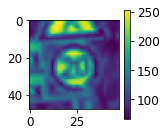

In [12]:
_st = f_start()
_folder = os.getcwd()+ "\\CSV\\"
_x_file = "x_train_gr_smpl.csv"
_y_file = "y_train_smpl.csv"
X = pd.read_csv(_folder+_x_file)
X.columns = ['x'+str(col) for col in X.columns]
y = pd.read_csv(_folder+_y_file)
y.columns = [*y.columns[:-1], 'label']
display(X.iloc[0:2,0:40])
plt.figure(figsize=(2,2))
plt.imshow(X.iloc[0:1].to_numpy().reshape(48,48))
plt.colorbar()
plt.grid(False)
# Class Definition
class_names = ['Speed Limit 20', 'Speed Limit 30', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70', 'Left Turn', 'Right Turn', 'Pedestrian', 'Children', 'Cycle Route']
print('Shape of X',X.shape,'Shape of y',y.shape)
_image_resize = 28
ar_sm = np.apply_along_axis(func1d=lambda img: cv2.resize(img.reshape(48,48), dsize=(_image_resize,_image_resize)), axis=1, arr=X.to_numpy()).reshape(-1, _image_resize*_image_resize)
X = pd.DataFrame(data=ar_sm)
X.columns = ['x'+str(col) for col in X.columns]
f_end(_st)

# Data Preprocessing

Shape of X is (9690, 784)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24
0,0.294994,0.291175,0.327226,0.3803,0.463371,0.445727,0.4962,0.648221,0.927102,0.974885,0.943787,0.805312,0.618011,0.60998,0.700509,0.832959,0.938531,0.916429,0.77581,0.547939,0.334109,0.325265,0.383922,0.360597,0.306756


Shape of X (9690, 784) Shape of y (9690, 1)
Processed in 0.42 seconds.


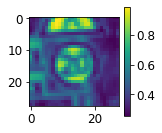

In [13]:
_st = f_start()
##### Normalization 
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X = X.astype('float32')
print('Shape of X is',X.shape)
display(X.iloc[0:1,0:25])
print('Shape of X',X.shape,'Shape of y',y.shape)
plt.figure(figsize=(2,2))
plt.imshow(X.iloc[0:1].to_numpy().reshape(_image_resize,_image_resize))
plt.colorbar()
plt.grid(False)
f_end(_st)

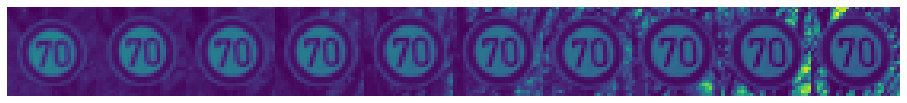

In [14]:
plt.figure(figsize=(16,16))
_plot_images=X.iloc[7400:7410].to_numpy()
f_PlotMultipleImages(_plot_images, images_per_row=10, size=_image_resize)
plt.show()

# Parameters

In [15]:
no_of_seeds  = 1330
no_of_folds  = 10
no_of_epochs = 30
ar_of_epochs = [1,10,20,30,40,50]
record_pred  = 15

# Part 1 - Neural Network 

***

## Q1 - K10 Folds Cross Validation

In [16]:
kf = KFold(n_splits = no_of_folds)
skf = StratifiedKFold(n_splits=no_of_folds, shuffle=True, random_state=no_of_seeds)

In [17]:
kfolds_cvs = [] #Cross Validation Scores
kfolds_counter = 0
kfolds_cr  = {}  #Classification Report
kfolds_roc = {}  #For ROC and AUC Scores
kfolds_cm  = []  #Confusion Matrix 
kfolds_hist= {}  #Stores the Model History

for train, test in skf.split(X, y):
#     Model
    _model_seq = f_createModel()
    _model_seq.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy','mean_squared_error'])
    _model_seq.fit(X.to_numpy()[train], y.to_numpy()[train], epochs=no_of_epochs)
    kfolds_hist[kfolds_counter+1] = _model_seq.fit(X.to_numpy()[train], y.to_numpy()[train], epochs=no_of_epochs, validation_data=(X.to_numpy()[test], y.to_numpy()[test]))
    
    _scores = _model_seq.evaluate(X.to_numpy()[test], y.to_numpy()[test], verbose=1)
    _y_pred_class = np.argmax(_model_seq.predict(X.to_numpy()[test]),axis=-1)
    
    kfolds_roc[kfolds_counter] = f_ROC_AUC_Score_Multiclass(y.to_numpy()[test].ravel(), _y_pred_class)
    kfolds_cr[kfolds_counter] = sklearn.metrics.classification_report(y.to_numpy()[test], _y_pred_class, output_dict=True, zero_division=0)
    
    for key, value in kfolds_cr.items():
        for i_k, i_v in kfolds_cr[key].items():
            if type(kfolds_cr[key][i_k])==dict:
                kfolds_cr[key][i_k]['folds'] = int(key+1)

    kfolds_cm.append(sklearn.metrics.confusion_matrix(y.to_numpy()[test], _y_pred_class))
    kfolds_cvs.append(_scores[1] * 100)
    kfolds_counter+=1

Epoch 1/30
273/273 [==============================] - 0s 2ms/step - loss: 1.5516 - accuracy: 0.4465 - mean_squared_error: 14.0493
Epoch 2/30
273/273 [==============================] - 0s 2ms/step - loss: 1.1086 - accuracy: 0.6395 - mean_squared_error: 14.0593
Epoch 3/30
273/273 [==============================] - 0s 2ms/step - loss: 0.8638 - accuracy: 0.7554 - mean_squared_error: 14.0681
Epoch 4/30
273/273 [==============================] - 0s 2ms/step - loss: 0.6981 - accuracy: 0.8100 - mean_squared_error: 14.0758
Epoch 5/30
273/273 [==============================] - 0s 2ms/step - loss: 0.5629 - accuracy: 0.8482 - mean_squared_error: 14.0826
Epoch 6/30
273/273 [==============================] - 1s 2ms/step - loss: 0.4690 - accuracy: 0.8786 - mean_squared_error: 14.0877
Epoch 7/30
273/273 [==============================] - 0s 2ms/step - loss: 0.4709 - accuracy: 0.8666 - mean_squared_error: 14.0911
Epoch 8/30
273/273 [==============================] - 1s 2ms/step - loss: 0.3649 - accurac

273/273 [==============================] - 0s 2ms/step - loss: 0.1014 - accuracy: 0.9682 - mean_squared_error: 14.1170 - val_loss: 0.1816 - val_accuracy: 0.9546 - val_mean_squared_error: 14.1164
Epoch 12/30
273/273 [==============================] - 0s 2ms/step - loss: 0.0875 - accuracy: 0.9759 - mean_squared_error: 14.1173 - val_loss: 0.1722 - val_accuracy: 0.9567 - val_mean_squared_error: 14.1164
Epoch 13/30
273/273 [==============================] - 0s 1ms/step - loss: 0.0702 - accuracy: 0.9830 - mean_squared_error: 14.1181 - val_loss: 0.1519 - val_accuracy: 0.9598 - val_mean_squared_error: 14.1179
Epoch 14/30
273/273 [==============================] - 1s 2ms/step - loss: 0.0559 - accuracy: 0.9868 - mean_squared_error: 14.1184 - val_loss: 0.2007 - val_accuracy: 0.9401 - val_mean_squared_error: 14.1166
Epoch 15/30
273/273 [==============================] - 1s 2ms/step - loss: 0.0744 - accuracy: 0.9780 - mean_squared_error: 14.1181 - val_loss: 0.1678 - val_accuracy: 0.9536 - val_mean_

273/273 [==============================] - 0s 1ms/step - loss: 0.2400 - accuracy: 0.9305 - mean_squared_error: 14.1065
Epoch 16/30
273/273 [==============================] - 0s 2ms/step - loss: 0.1990 - accuracy: 0.9447 - mean_squared_error: 14.1082
Epoch 17/30
273/273 [==============================] - 0s 2ms/step - loss: 0.1864 - accuracy: 0.9499 - mean_squared_error: 14.1090
Epoch 18/30
273/273 [==============================] - 0s 2ms/step - loss: 0.1802 - accuracy: 0.9522 - mean_squared_error: 14.1096
Epoch 19/30
273/273 [==============================] - 0s 1ms/step - loss: 0.1712 - accuracy: 0.9533 - mean_squared_error: 14.1102
Epoch 20/30
273/273 [==============================] - 0s 1ms/step - loss: 0.1651 - accuracy: 0.9553 - mean_squared_error: 14.1108
Epoch 21/30
273/273 [==============================] - 0s 2ms/step - loss: 0.1659 - accuracy: 0.9553 - mean_squared_error: 14.1111
Epoch 22/30
273/273 [==============================] - 0s 1ms/step - loss: 0.1475 - accuracy: 0

273/273 [==============================] - 1s 2ms/step - loss: 0.0728 - accuracy: 0.9800 - mean_squared_error: 14.1176 - val_loss: 0.1926 - val_accuracy: 0.9567 - val_mean_squared_error: 14.1169
Epoch 20/30
273/273 [==============================] - 1s 2ms/step - loss: 0.0679 - accuracy: 0.9807 - mean_squared_error: 14.1179 - val_loss: 0.4482 - val_accuracy: 0.8978 - val_mean_squared_error: 14.1144
Epoch 21/30
273/273 [==============================] - 1s 2ms/step - loss: 0.0645 - accuracy: 0.9823 - mean_squared_error: 14.1184 - val_loss: 0.1867 - val_accuracy: 0.9577 - val_mean_squared_error: 14.1166
Epoch 22/30
273/273 [==============================] - 1s 2ms/step - loss: 0.0892 - accuracy: 0.9740 - mean_squared_error: 14.1178 - val_loss: 0.3223 - val_accuracy: 0.9185 - val_mean_squared_error: 14.1153
Epoch 23/30
273/273 [==============================] - 0s 2ms/step - loss: 0.0747 - accuracy: 0.9779 - mean_squared_error: 14.1180 - val_loss: 0.1851 - val_accuracy: 0.9639 - val_mean_

273/273 [==============================] - 0s 1ms/step - loss: 0.1169 - accuracy: 0.9703 - mean_squared_error: 14.1137
Epoch 29/30
273/273 [==============================] - 0s 2ms/step - loss: 0.1333 - accuracy: 0.9628 - mean_squared_error: 14.1137
Epoch 30/30
273/273 [==============================] - 0s 1ms/step - loss: 0.1384 - accuracy: 0.9620 - mean_squared_error: 14.1139
Epoch 1/30
273/273 [==============================] - 1s 2ms/step - loss: 0.1141 - accuracy: 0.9681 - mean_squared_error: 14.1146 - val_loss: 0.1935 - val_accuracy: 0.9546 - val_mean_squared_error: 14.1134
Epoch 2/30
273/273 [==============================] - 0s 2ms/step - loss: 0.0997 - accuracy: 0.9737 - mean_squared_error: 14.1151 - val_loss: 0.1726 - val_accuracy: 0.9567 - val_mean_squared_error: 14.1142
Epoch 3/30
273/273 [==============================] - 0s 2ms/step - loss: 0.1486 - accuracy: 0.9594 - mean_squared_error: 14.1146 - val_loss: 0.2028 - val_accuracy: 0.9515 - val_mean_squared_error: 14.1139
E

273/273 [==============================] - 1s 2ms/step - loss: 0.0472 - accuracy: 0.9882 - mean_squared_error: 14.1196 - val_loss: 0.2005 - val_accuracy: 0.9546 - val_mean_squared_error: 14.1177
Epoch 29/30
273/273 [==============================] - 1s 2ms/step - loss: 0.1027 - accuracy: 0.9719 - mean_squared_error: 14.1184 - val_loss: 0.1774 - val_accuracy: 0.9680 - val_mean_squared_error: 14.1176
Epoch 30/30
31/31 [==============================] - 0s 1ms/step - loss: 0.1548 - accuracy: 0.9680 - mean_squared_error: 14.1181
Epoch 1/30
273/273 [==============================] - 0s 1ms/step - loss: 1.5885 - accuracy: 0.4534 - mean_squared_error: 14.0491
Epoch 2/30
273/273 [==============================] - 0s 1ms/step - loss: 1.1282 - accuracy: 0.6471 - mean_squared_error: 14.0589
Epoch 3/30
273/273 [==============================] - 0s 1ms/step - loss: 0.8686 - accuracy: 0.7495 - mean_squared_error: 14.0682: 0s - loss: 0.8932 - accuracy: 0.7380 - mean_squared_error: 13.
Epoch 4/30
273/

Epoch 18/30
273/273 [==============================] - 0s 2ms/step - loss: 0.0760 - accuracy: 0.9781 - mean_squared_error: 14.1176 - val_loss: 0.1364 - val_accuracy: 0.9598 - val_mean_squared_error: 14.1171
Epoch 19/30
273/273 [==============================] - 1s 2ms/step - loss: 0.0800 - accuracy: 0.9770 - mean_squared_error: 14.1175 - val_loss: 0.1192 - val_accuracy: 0.9659 - val_mean_squared_error: 14.1177
Epoch 20/30
273/273 [==============================] - 0s 1ms/step - loss: 0.0722 - accuracy: 0.9806 - mean_squared_error: 14.1181 - val_loss: 0.1296 - val_accuracy: 0.9701 - val_mean_squared_error: 14.1174
Epoch 21/30
273/273 [==============================] - 0s 1ms/step - loss: 0.0912 - accuracy: 0.9734 - mean_squared_error: 14.1176 - val_loss: 0.1505 - val_accuracy: 0.9556 - val_mean_squared_error: 14.1175
Epoch 22/30
273/273 [==============================] - 0s 1ms/step - loss: 0.0591 - accuracy: 0.9847 - mean_squared_error: 14.1184 - val_loss: 0.0993 - val_accuracy: 0.9752

Epoch 8/30
273/273 [==============================] - 0s 1ms/step - loss: 0.1236 - accuracy: 0.9625 - mean_squared_error: 14.1147 - val_loss: 0.1546 - val_accuracy: 0.9618 - val_mean_squared_error: 14.1151
Epoch 9/30
273/273 [==============================] - 0s 1ms/step - loss: 0.1199 - accuracy: 0.9639 - mean_squared_error: 14.1152 - val_loss: 0.2040 - val_accuracy: 0.9432 - val_mean_squared_error: 14.1148
Epoch 10/30
273/273 [==============================] - 0s 2ms/step - loss: 0.1003 - accuracy: 0.9720 - mean_squared_error: 14.1158 - val_loss: 0.1529 - val_accuracy: 0.9639 - val_mean_squared_error: 14.1155
Epoch 11/30
273/273 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.9739 - mean_squared_error: 14.1161 - val_loss: 0.1887 - val_accuracy: 0.9525 - val_mean_squared_error: 14.1152
Epoch 12/30
273/273 [==============================] - 0s 2ms/step - loss: 0.1146 - accuracy: 0.9673 - mean_squared_error: 14.1154 - val_loss: 0.2009 - val_accuracy: 0.9505 -

#### Accuracy Plot

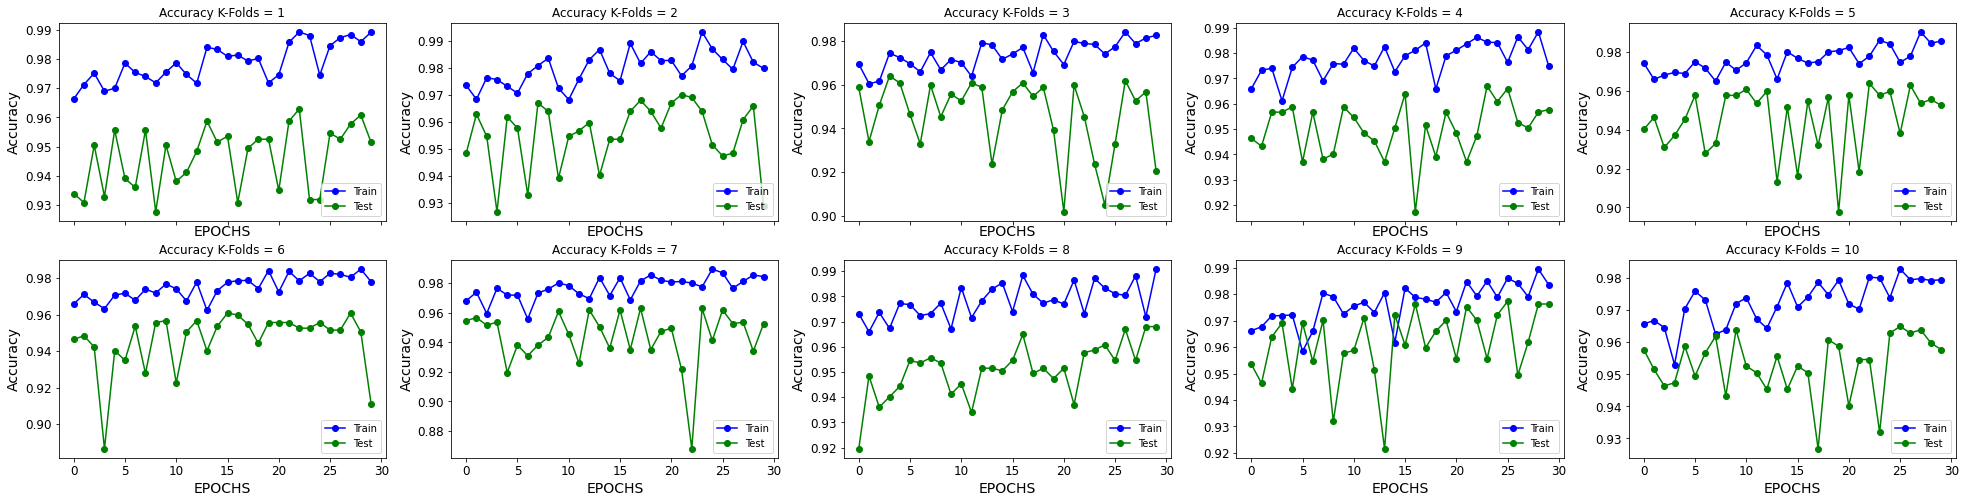

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(34,8))
for ax, _fold_counter in zip(axes.flatten(), kfolds_hist):
    ax.plot(kfolds_hist[_fold_counter].history['accuracy'], marker='o',label='Train', color='blue')
    ax.plot(kfolds_hist[_fold_counter].history['val_accuracy'], marker='o', label='Test', color='green')
    ax.set_title('Accuracy K-Folds = '+str(_fold_counter))
    ax.set(xlabel='EPOCHS', ylabel='Accuracy')
    ax.legend(loc='lower right')

#### Loss Plot

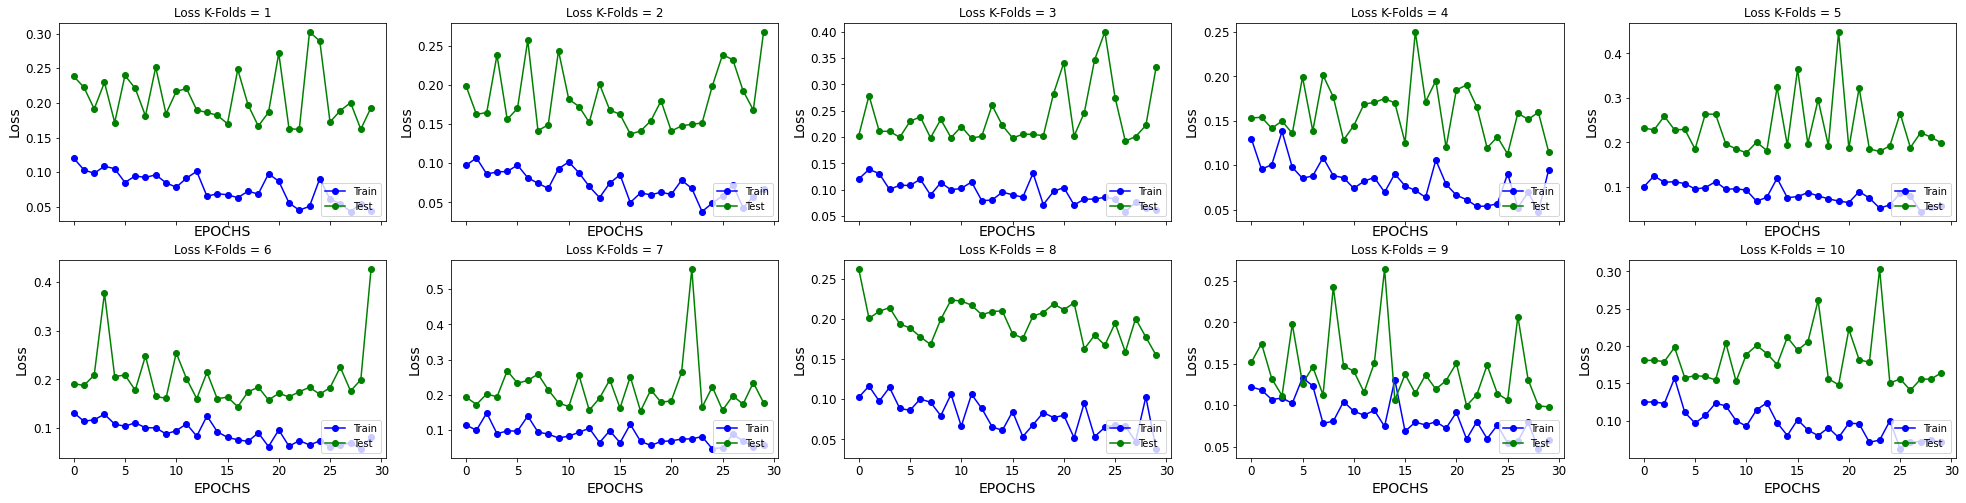

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(34,8))
for ax, _fold_counter in zip(axes.flatten(), kfolds_hist):
    ax.plot(kfolds_hist[_fold_counter].history['loss'], marker='o',label='Train', color='blue')
    ax.plot(kfolds_hist[_fold_counter].history['val_loss'], marker='o', label='Test', color='green')
    ax.set_title('Loss K-Folds = '+str(_fold_counter))
    ax.set(xlabel='EPOCHS', ylabel='Loss')
    ax.legend(loc='lower right')

#### Mean Squared Error Plot

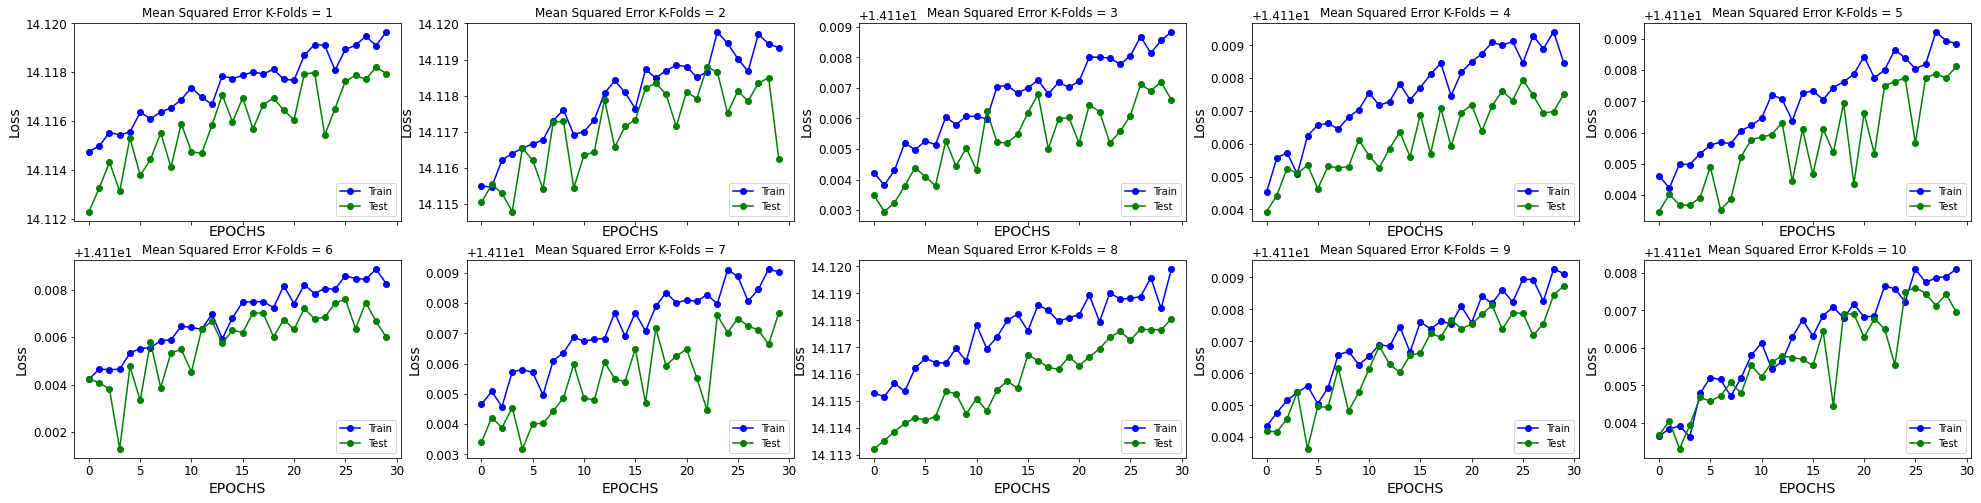

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(34,8))
for ax, _fold_counter in zip(axes.flatten(), kfolds_hist):
    ax.plot(kfolds_hist[_fold_counter].history['mean_squared_error'], marker='o',label='Train', color='blue')
    ax.plot(kfolds_hist[_fold_counter].history['val_mean_squared_error'], marker='o', label='Test', color='green')
    ax.set_title('Mean Squared Error K-Folds = '+str(_fold_counter))
    ax.set(xlabel='EPOCHS', ylabel='Loss')
    ax.legend(loc='lower right')

### Classification Report K-10 with ROC

In [21]:
np_roc = []
for key, value in kfolds_roc.items():
    kfolds_roc[key]['accuracy']=''
    kfolds_roc[key]['macro avg']=''
    kfolds_roc[key]['weighted avg']=''

for key, value in kfolds_roc.items():
    for i_k, i_v in value.items():
        np_roc.append(i_v)

In [22]:
df_folds_cl_rep = pd.DataFrame()
for folds in range(len(kfolds_cr)):
    df_folds_cl_rep = df_folds_cl_rep.append(pd.DataFrame(kfolds_cr[folds]).transpose(),ignore_index=False)
df_folds_cl_rep.loc['accuracy','precision']=''
df_folds_cl_rep.loc['accuracy','recall']=''
df_folds_cl_rep.loc['accuracy','folds']= np.NAN
df_folds_cl_rep = df_folds_cl_rep.fillna(method='ffill')
df_folds_cl_rep['roc_auc_score']=np_roc

In [23]:
df_folds_cl_rep

,precision,recall,f1-score,support,folds,roc_auc_score
0,1,0.904762,0.950000,21.000000,1.0,0.952381
1,0.980392,0.900901,0.938967,222.000000,1.0,0.947773
2,0.895161,0.986667,0.938689,225.000000,1.0,0.97586
3,0.978873,0.985816,0.982332,141.000000,1.0,0.991096
4,0.959391,0.954545,0.956962,198.000000,1.0,0.972085
5,0.84,1,0.913043,21.000000,1.0,0.99789
6,1,0.861111,0.925373,36.000000,1.0,0.930556
7,1,1,1.000000,24.000000,1.0,1
8,0.981132,0.962963,0.971963,54.000000,1.0,0.980935
9,0.961538,0.925926,0.943396,27.000000,1.0,0.962432


### ROC AUC Score Plot

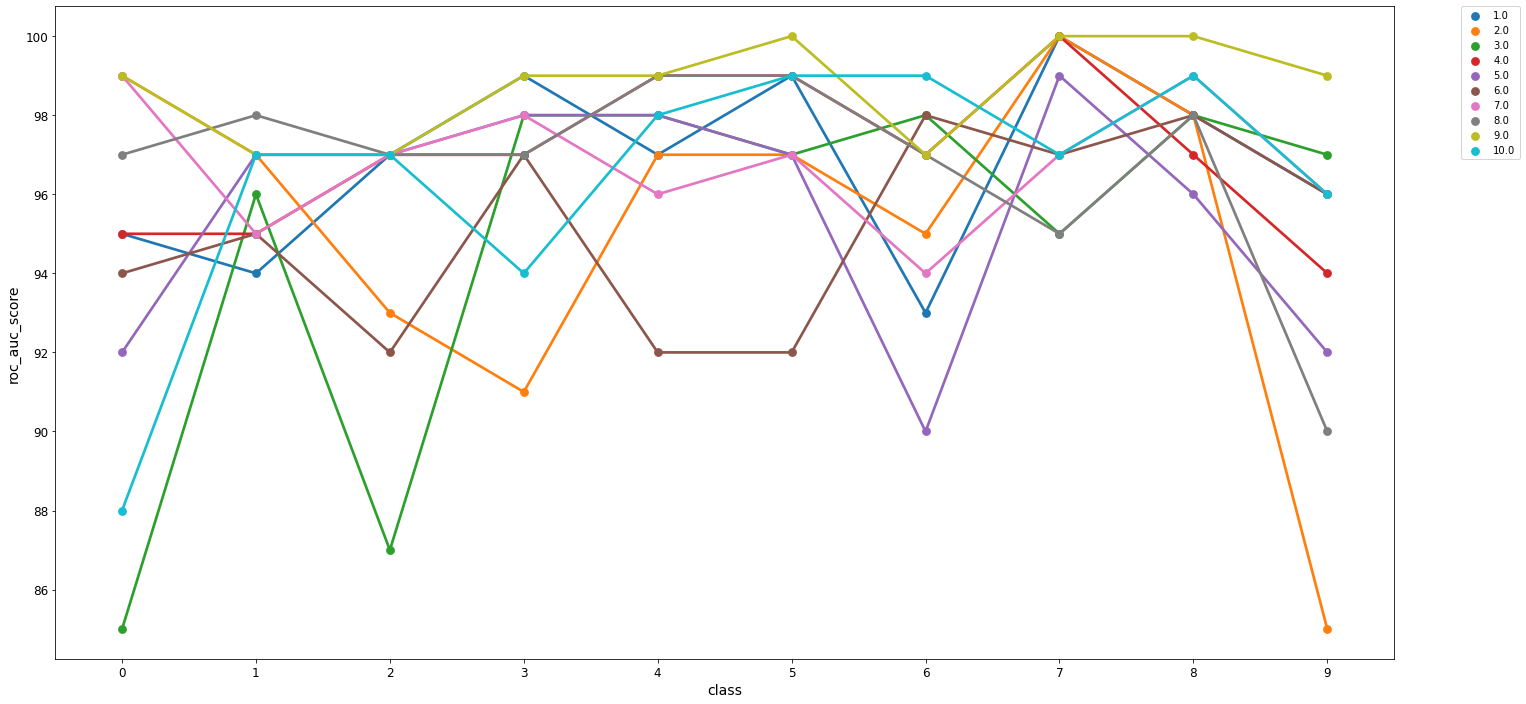

In [24]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(24,12))
_data = df_folds_cl_rep[df_folds_cl_rep.roc_auc_score!='']
_data.loc[:,'roc_auc_score'] = _data.loc[:,'roc_auc_score'].apply(lambda x:x*100).astype(int)
_data = _data.reset_index()
_data.rename(columns={'index':'class'}, inplace=True)
palette = sns.color_palette("bright", 10)
ax = sns.pointplot(data=_data, x="class", y="roc_auc_score", hue='folds', marker='o', legend='full', palette='tab10', linewidth='2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Confusion Matrix K-10

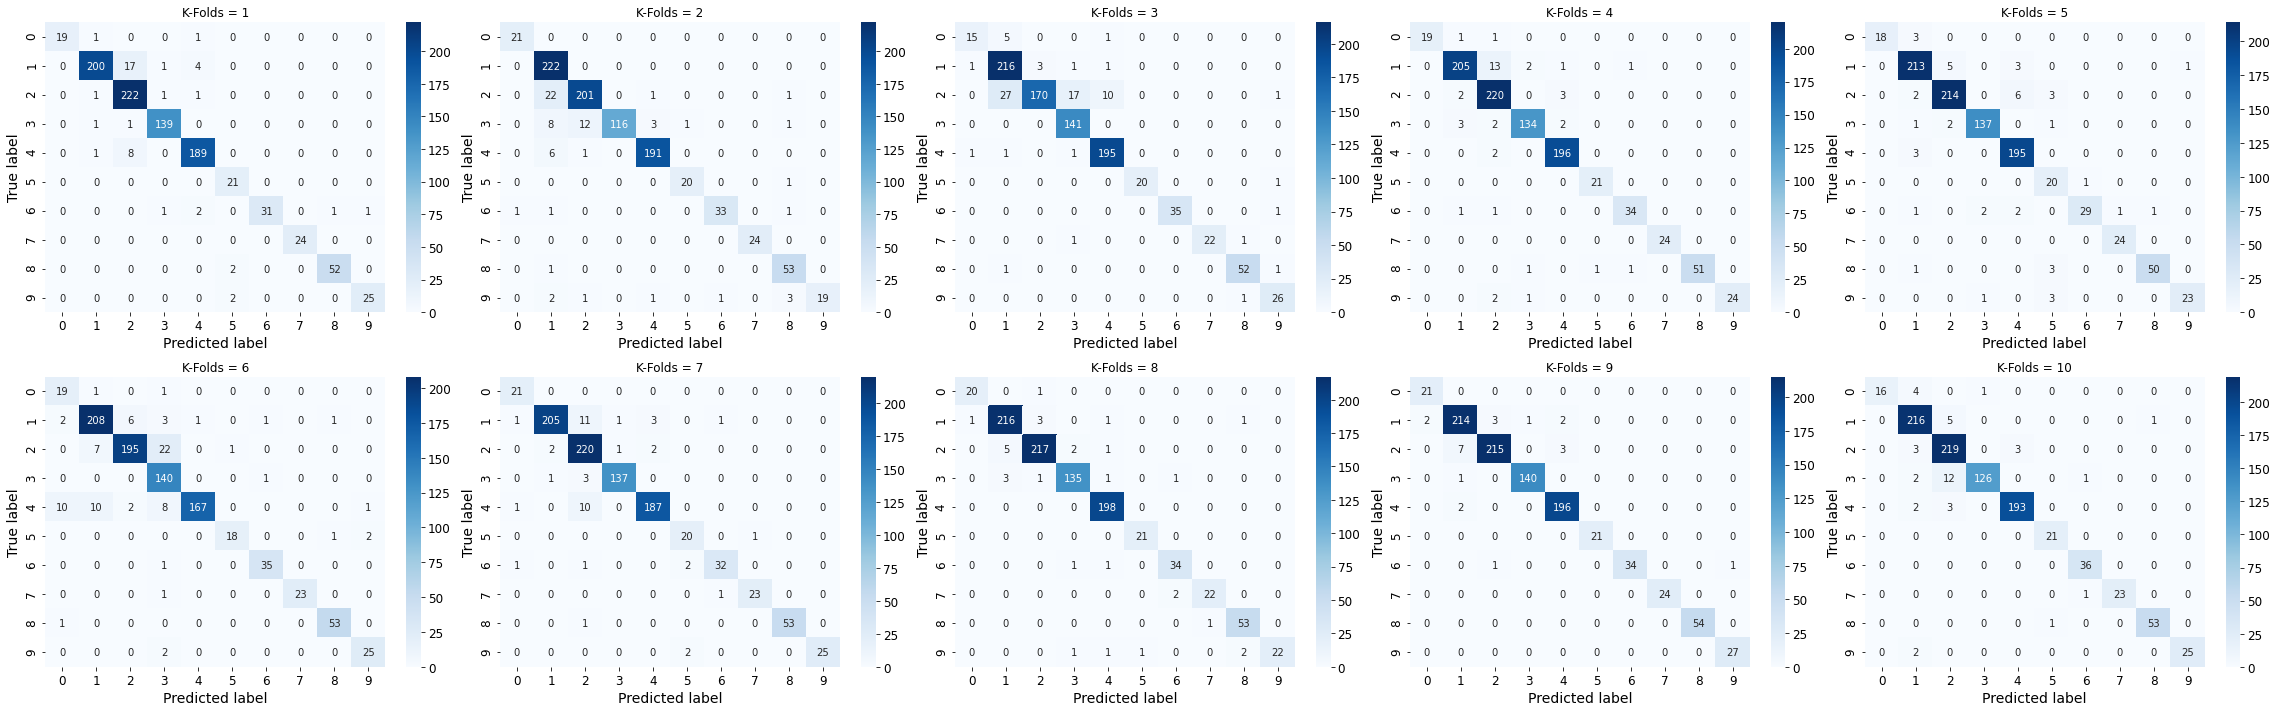

In [25]:
fig, axes = plt.subplots(2,5,figsize=(32,10))
for _fold_counter in range(len(kfolds_cm)):
    row = _fold_counter // 5
    col = _fold_counter % 5
    ax_curr = axes[row, col]
    sns.heatmap(kfolds_cm[_fold_counter], annot=True, cmap=plt.cm.Blues, fmt='g', ax=ax_curr)
    _chart_title = 'K-Folds = '+str(_fold_counter+1)
    ax_curr.set_title(_chart_title)
    ax_curr.set(xlabel='Predicted label', ylabel='True label')
    plt.tight_layout()

### Cross Validation Scores

In [26]:
df_folds_cvs = pd.DataFrame(kfolds_cvs)
df_folds_cvs.columns = ['cross_validation_score']
df_folds_cvs['k_folds'] = range(1,no_of_folds+1)
df_folds_cvs['epochs'] = no_of_epochs
df_folds_cvs.sort_values(by=['cross_validation_score'], ascending=False)

,cross_validation_score,k_folds,epochs
8,97.626418,9,30
7,96.800828,8,30
3,95.768833,4,30
9,95.768833,10,30
4,95.252836,5,30
6,95.252836,7,30
0,95.149636,1,30
1,92.879260,2,30
2,92.053664,3,30
5,91.124868,6,30


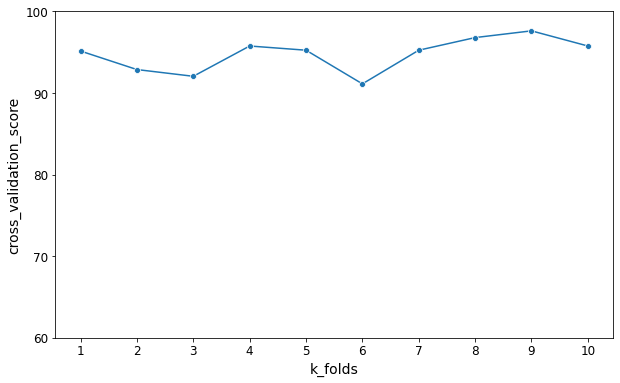

In [27]:
fig, axes = plt.subplots(figsize=(10,6))
ax = sns.lineplot(data=df_folds_cvs, x="k_folds", y="cross_validation_score", marker='o')
ax.set(xticks=df_folds_cvs.k_folds.values)
ax.set(yticks=np.arange(6,11)*10)
plt.show()

In [28]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(kfolds_cvs), np.std(kfolds_cvs)))

94.77% (+/- 1.98%)


## Question No. 3

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=no_of_seeds)
print('X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)

X_train (7752, 784) X_test (1938, 784) y_train (7752, 1) y_test (1938, 1)


### Model Evaluation

In [30]:
if os.path.exists("logs/fit/seq/") : shutil.rmtree("logs/fit/seq/")
model_seq = f_createModel()
model_seq.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_seq.fit(X.to_numpy()[train], y.to_numpy()[train], epochs=no_of_epochs, validation_data=(X.to_numpy()[test], y.to_numpy()[test]))
    
log_dir = "logs/fit/seq/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
es_callback = EarlyStopping(monitor='loss', patience=3) # This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs
model_seq.fit(x=X_train, 
              y=y_train, 
              epochs=no_of_epochs, 
              verbose=0,
              callbacks=[tensorboard_callback,es_callback],
              validation_data=(X_test, y_test),
             )
test_loss, test_acc = model_seq.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy:', test_acc)
%reload_ext tensorboard
# %tensorboard --logdir logs/fit/seq/ --host localhost --port 8088
# Launch http://localhost:8088/

Epoch 1/30
273/273 [==============================] - 1s 2ms/step - loss: 1.5934 - accuracy: 0.4341 - val_loss: 1.2649 - val_accuracy: 0.5841
Epoch 2/30
273/273 [==============================] - 0s 2ms/step - loss: 1.1435 - accuracy: 0.6285 - val_loss: 0.9685 - val_accuracy: 0.7131
Epoch 3/30
273/273 [==============================] - 0s 2ms/step - loss: 0.8875 - accuracy: 0.7421 - val_loss: 0.7897 - val_accuracy: 0.7657
Epoch 4/30
273/273 [==============================] - 1s 2ms/step - loss: 0.7087 - accuracy: 0.8059 - val_loss: 0.6246 - val_accuracy: 0.8452
Epoch 5/30
273/273 [==============================] - 0s 2ms/step - loss: 0.5962 - accuracy: 0.8355 - val_loss: 0.6153 - val_accuracy: 0.8070
Epoch 6/30
273/273 [==============================] - 0s 2ms/step - loss: 0.5219 - accuracy: 0.8545 - val_loss: 0.4663 - val_accuracy: 0.8885
Epoch 7/30
273/273 [==============================] - 0s 2ms/step - loss: 0.4533 - accuracy: 0.8768 - val_loss: 0.4099 - val_accuracy: 0.8989
Epoch 

#### Accurancy and Loss Plot

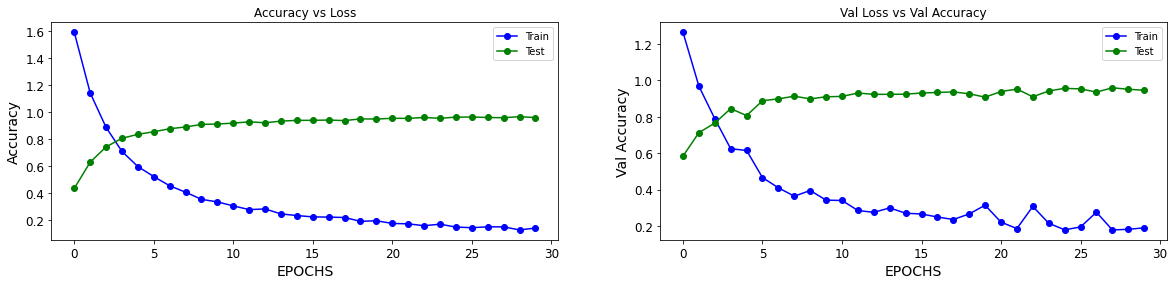

In [31]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,4))
ax1.plot(history.history['loss'], marker='o', label='Train', color='b')
ax1.plot(history.history['accuracy'], marker='o', label='Test', color='g')
ax1.set_title('Accuracy vs Loss')
ax1.set(xlabel='EPOCHS', ylabel='Accuracy')
ax1.legend(loc='upper right')
ax2.plot(history.history['val_loss'], marker='o', label='Train', color='b')
ax2.plot(history.history['val_accuracy'], marker='o', label='Test', color='g')
ax2.set_title('Val Loss vs Val Accuracy')
ax2.set(xlabel='EPOCHS', ylabel='Val Accuracy')
ax2.legend(loc='upper right')

### Predictions

In [32]:
y_predict = model_seq.predict(X_test)
y_pred_class = np.argmax(model_seq.predict(X_test), axis=-1) #predict_classes is depereciated

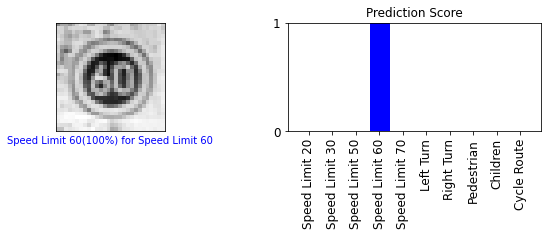

In [33]:
f_PlotPresentPredictions(record_pred, y_predict[record_pred], y_test, X_test)

### Classification Report

In [34]:
roc_auc_score = f_ROC_AUC_Score_Multiclass(y_test.to_numpy().ravel(),y_pred_class)

In [35]:
print(y_test.to_numpy().ravel(), len(y_test.to_numpy().ravel()))
print(y_pred_class, len(y_pred_class))

[2 4 4 ... 2 2 2] 1938
[2 4 4 ... 2 2 2] 1938


In [36]:
roc_auc_score['accuracy']=''
roc_auc_score['macro avg']=''
roc_auc_score['weighted avg']=''
np_roc = []
for key, value in roc_auc_score.items():
    np_roc.append(value)

In [37]:
_classification_report = sklearn.metrics.classification_report(y_test, y_pred_class, output_dict=True)
df_seq_cr = pd.DataFrame(_classification_report).transpose()
df_seq_cr.loc['accuracy','precision']=''
df_seq_cr.loc['accuracy','recall']=''
df_seq_cr['roc_auc_score'] = np_roc
df_seq_cr

,precision,recall,f1-score,support,roc_auc_score
0,1,0.853659,0.921053,41.000000,0.926829
1,0.960739,0.951945,0.956322,437.000000,0.97031
2,0.949339,0.975113,0.962054,442.000000,0.979869
3,1,0.94382,0.971098,267.000000,0.97191
4,0.96092,0.995238,0.977778,420.000000,0.99202
5,1,0.928571,0.962963,42.000000,0.964286
6,0.948052,0.973333,0.960526,75.000000,0.985593
7,1,1,1.000000,50.000000,1
8,0.990909,1,0.995434,109.000000,0.999727
9,1,0.963636,0.981481,55.000000,0.981818


In [38]:
df_seq_cr.reset_index(inplace=True)
df_seq_cr = df_seq_cr.rename(columns = {'index':'Measure','f1-score':'f1_score'})
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='0', class_names[0], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='1', class_names[1], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='2', class_names[2], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='3', class_names[3], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='4', class_names[4], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='5', class_names[5], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='6', class_names[6], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='7', class_names[7], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='8', class_names[8], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='9', class_names[9], df_seq_cr['Measure'])
df_seq_cr

,Measure,precision,recall,f1_score,support,roc_auc_score
0,Speed Limit 20,1,0.853659,0.921053,41.000000,0.926829
1,Speed Limit 30,0.960739,0.951945,0.956322,437.000000,0.97031
2,Speed Limit 50,0.949339,0.975113,0.962054,442.000000,0.979869
3,Speed Limit 60,1,0.94382,0.971098,267.000000,0.97191
4,Speed Limit 70,0.96092,0.995238,0.977778,420.000000,0.99202
5,Left Turn,1,0.928571,0.962963,42.000000,0.964286
6,Right Turn,0.948052,0.973333,0.960526,75.000000,0.985593
7,Pedestrian,1,1,1.000000,50.000000,1
8,Children,0.990909,1,0.995434,109.000000,0.999727
9,Cycle Route,1,0.963636,0.981481,55.000000,0.981818


### ROC AUC Score Plot

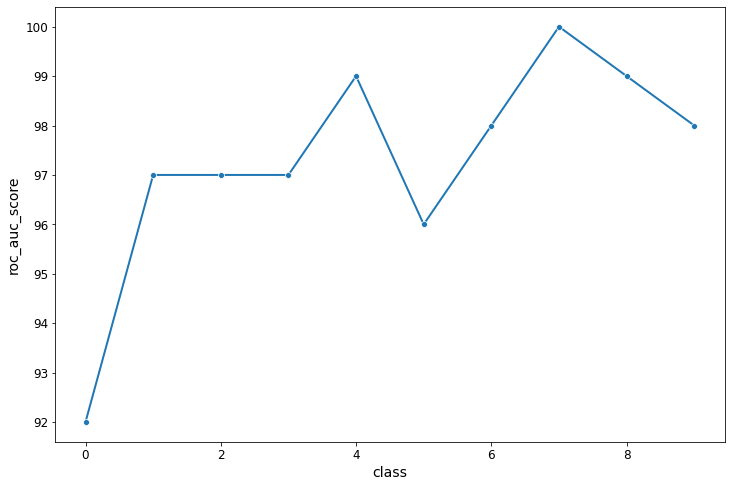

In [39]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(12,8))
_data = df_seq_cr[df_seq_cr.roc_auc_score!='']
_data.loc[:,'roc_auc_score'] = _data.loc[:,'roc_auc_score'].apply(lambda x:x*100).astype(int)
_data = _data.reset_index()
_data.rename(columns={'index':'class'}, inplace=True)
palette = sns.color_palette("bright", 10)
ax = sns.lineplot(data=_data, x="class", y="roc_auc_score",  marker='o', palette='tab10', linewidth='2')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Confusion Matrix

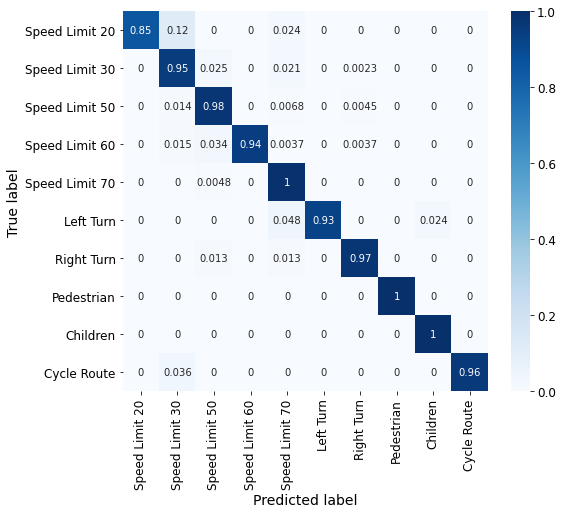

In [40]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_class).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=5)
con_mat_df = pd.DataFrame(con_mat_norm,index = class_names, columns = class_names)
con_mat_df
figure = plt.figure(figsize=(8, 7))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### TP, TN, FP, FN

In [41]:
df_seq_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, y_pred_class))
df_seq_cm.columns=class_names
df_seq_cm.index = class_names
df_seq_cm

,Speed Limit 20,Speed Limit 30,Speed Limit 50,Speed Limit 60,Speed Limit 70,Left Turn,Right Turn,Pedestrian,Children,Cycle Route
Speed Limit 20,35,5,0,0,1,0,0,0,0,0
Speed Limit 30,0,416,11,0,9,0,1,0,0,0
Speed Limit 50,0,6,431,0,3,0,2,0,0,0
Speed Limit 60,0,4,9,252,1,0,1,0,0,0
Speed Limit 70,0,0,2,0,418,0,0,0,0,0
Left Turn,0,0,0,0,2,39,0,0,1,0
Right Turn,0,0,1,0,1,0,73,0,0,0
Pedestrian,0,0,0,0,0,0,0,50,0,0
Children,0,0,0,0,0,0,0,0,109,0
Cycle Route,0,2,0,0,0,0,0,0,0,53


<AxesSubplot:title={'center':'Confusion Matrix (TP, TN, FP, FN)'}>

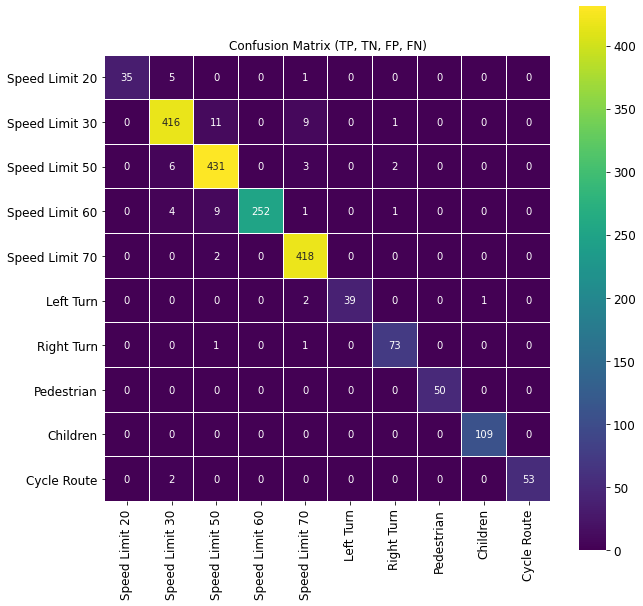

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Confusion Matrix (TP, TN, FP, FN)')
sns.heatmap(df_seq_cm, 
            cmap="viridis",
            fmt=".0f",
            annot_kws={"fontsize":10},
            square=True,
            annot=True,
           linewidths=.01,
           ax=ax)

### Grid Search

In [43]:
model = KerasClassifier(build_fn=f_ModelGridSearch, verbose=1)
optimizers = ['adam']
# init = ['glorot_uniform', 'normal', 'uniform']
init = ['glorot_uniform']
epochs = ar_of_epochs

param_grid = dict(optimizer=optimizers, epochs=epochs, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    verbose=1,
                    return_train_score=True,
                    n_jobs=2)

In [44]:
grid_result = grid.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  3.8min finished


Epoch 1/50
303/303 [==============================] - 0s 2ms/step - loss: 1.5069 - accuracy: 0.4709
Epoch 2/50
303/303 [==============================] - 1s 2ms/step - loss: 1.0161 - accuracy: 0.6851
Epoch 3/50
303/303 [==============================] - 1s 2ms/step - loss: 0.7743 - accuracy: 0.7728
Epoch 4/50
303/303 [==============================] - 1s 2ms/step - loss: 0.6110 - accuracy: 0.8266
Epoch 5/50
303/303 [==============================] - 1s 2ms/step - loss: 0.5064 - accuracy: 0.8638
Epoch 6/50
303/303 [==============================] - 1s 2ms/step - loss: 0.4370 - accuracy: 0.8819
Epoch 7/50
303/303 [==============================] - 1s 2ms/step - loss: 0.3817 - accuracy: 0.8973
Epoch 8/50
303/303 [==============================] - 1s 2ms/step - loss: 0.3397 - accuracy: 0.9141
Epoch 9/50
303/303 [==============================] - 1s 3ms/step - loss: 0.3015 - accuracy: 0.9216
Epoch 10/50
303/303 [==============================] - 1s 2ms/step - loss: 0.2902 - accuracy: 0.9236

In [45]:
gr_results = grid_result.cv_results_

In [46]:
scores_df = pd.DataFrame(gr_results).sort_values(by=['param_epochs','param_init'])
scores_df = scores_df.drop(['params'], axis=1)
scores_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_init,param_optimizer,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.363003,0.131852,0.518797,0.155871,1,glorot_uniform,adam,0.010836,0.263158,0.170795,0.089783,0.114551,0.129825,0.084204,6,0.605779,0.566821,0.526574,0.516254,0.669505,0.576987,0.056075
1,5.398315,0.270369,0.652999,0.130289,10,glorot_uniform,adam,0.530960,0.585655,0.631063,0.421569,0.161507,0.466151,0.167615,5,0.951109,0.896930,0.928148,0.922472,0.931244,0.925980,0.017436
2,10.280823,0.231901,0.737201,0.151508,20,glorot_uniform,adam,0.386481,0.577915,0.713106,0.639319,0.146543,0.492673,0.204179,4,0.967105,0.944659,0.960913,0.948787,0.964138,0.957121,0.008810
3,15.909646,1.132811,0.650398,0.136876,30,glorot_uniform,adam,0.554696,0.533540,0.692982,0.652219,0.154283,0.517544,0.191055,3,0.983230,0.948529,0.970846,0.979102,0.973297,0.971001,0.012045
4,19.898211,0.184484,0.651304,0.126011,40,glorot_uniform,adam,0.568111,0.663571,0.702270,0.653767,0.155315,0.548607,0.201468,2,0.988261,0.984907,0.980908,0.984649,0.962848,0.980315,0.009038
5,23.544635,1.974868,0.525799,0.107451,50,glorot_uniform,adam,0.655831,0.762126,0.782766,0.665635,0.149639,0.603199,0.232330,1,0.993034,0.993808,0.988648,0.979231,0.963622,0.983669,0.011286


In [47]:
scores_df_gp = scores_df.groupby(['param_epochs'], as_index=False).agg({'mean_test_score':'sum','mean_train_score':'sum'})
scores_df_gp

,param_epochs,mean_test_score,mean_train_score
0,1,0.129825,0.576987
1,10,0.466151,0.925980
2,20,0.492673,0.957121
3,30,0.517544,0.971001
4,40,0.548607,0.980315
5,50,0.603199,0.983669


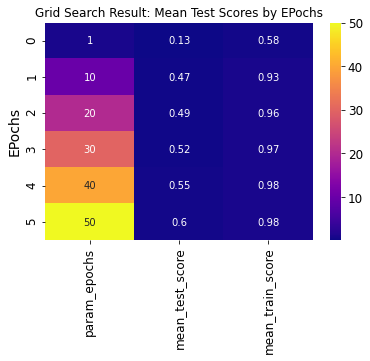

In [48]:
sns.heatmap(scores_df_gp, annot=True, cmap='plasma')
plt.title('Grid Search Result: Mean Test Scores by EPochs');
plt.ylabel('EPochs');

## Question No. 4

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.60, random_state=no_of_seeds)
print('X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)

X_train (3876, 784) X_test (5814, 784) y_train (3876, 1) y_test (5814, 1)


### Model Evaluation

In [50]:
if os.path.exists("logs/fit/seq/") : shutil.rmtree("logs/fit/seq/")
model_seq = f_createModel()
model_seq.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_seq.fit(X.to_numpy()[train], y.to_numpy()[train], epochs=no_of_epochs, validation_data=(X.to_numpy()[test], y.to_numpy()[test]))
log_dir = "logs/fit/seq/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
es_callback = EarlyStopping(monitor='loss', patience=3) # This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs
model_seq.fit(x=X_train, 
              y=y_train, 
              epochs=no_of_epochs, 
              verbose=0,
              callbacks=[tensorboard_callback,es_callback],
              validation_data=(X_test, y_test),
             )
test_loss, test_acc = model_seq.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy:', test_acc)
# %reload_ext tensorboard
# %tensorboard --logdir logs/fit/seq/ --host localhost --port 8088
# Launch http://localhost:8088/

Epoch 1/30
273/273 [==============================] - 1s 2ms/step - loss: 1.5839 - accuracy: 0.4317 - val_loss: 1.2485 - val_accuracy: 0.5820
Epoch 2/30
273/273 [==============================] - 1s 3ms/step - loss: 1.1403 - accuracy: 0.6260 - val_loss: 1.0397 - val_accuracy: 0.6708
Epoch 3/30
273/273 [==============================] - 1s 3ms/step - loss: 0.8811 - accuracy: 0.7440 - val_loss: 0.7676 - val_accuracy: 0.7853
Epoch 4/30
273/273 [==============================] - 1s 2ms/step - loss: 0.7135 - accuracy: 0.8023 - val_loss: 0.6407 - val_accuracy: 0.8380
Epoch 5/30
273/273 [==============================] - 1s 2ms/step - loss: 0.5980 - accuracy: 0.8375 - val_loss: 0.5290 - val_accuracy: 0.8751
Epoch 6/30
273/273 [==============================] - 1s 2ms/step - loss: 0.5030 - accuracy: 0.8694 - val_loss: 0.4602 - val_accuracy: 0.8927
Epoch 7/30
273/273 [==============================] - 1s 2ms/step - loss: 0.4387 - accuracy: 0.8906 - val_loss: 0.3908 - val_accuracy: 0.9174
Epoch 

#### Accurancy and Loss Plot

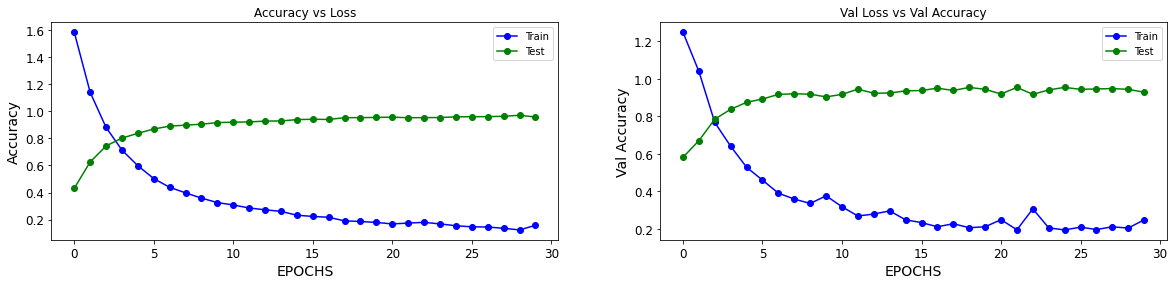

In [51]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,4))
ax1.plot(history.history['loss'], marker='o', label='Train', color='b')
ax1.plot(history.history['accuracy'], marker='o', label='Test', color='g')
ax1.set_title('Accuracy vs Loss')
ax1.set(xlabel='EPOCHS', ylabel='Accuracy')
ax1.legend(loc='upper right')
ax2.plot(history.history['val_loss'], marker='o', label='Train', color='b')
ax2.plot(history.history['val_accuracy'], marker='o', label='Test', color='g')
ax2.set_title('Val Loss vs Val Accuracy')
ax2.set(xlabel='EPOCHS', ylabel='Val Accuracy')
ax2.legend(loc='upper right')

### Predictions

In [52]:
y_predict = model_seq.predict(X_test)
y_pred_class = np.argmax(model_seq.predict(X_test), axis=-1) #predict_classes is depereciated

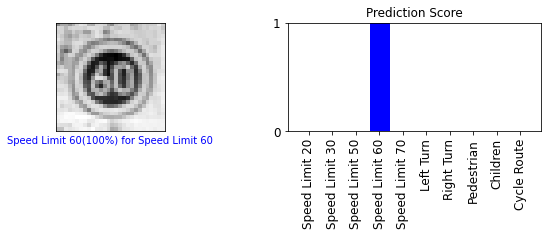

In [53]:
record_pred=15
f_PlotPresentPredictions(record_pred, y_predict[record_pred], y_test, X_test)

### Classification Report

In [54]:
print(y_test.to_numpy().ravel(), len(y_test.to_numpy().ravel()))
print(y_pred_class, len(y_pred_class))
# [2 1 1 ... 1 2 9] 1938
# [4 1 1 ... 1 3 2] 1938

[2 4 4 ... 0 3 1] 5814
[2 4 4 ... 0 3 1] 5814


In [55]:
roc_auc_score = f_ROC_AUC_Score_Multiclass(y_test.to_numpy().ravel(),y_pred_class)

In [56]:
roc_auc_score['accuracy']=''
roc_auc_score['macro avg']=''
roc_auc_score['weighted avg']=''
np_roc = []
for key, value in roc_auc_score.items():
    np_roc.append(value)

In [57]:
_classification_report = sklearn.metrics.classification_report(y_test, y_pred_class, output_dict=True)
df_seq_cr = pd.DataFrame(_classification_report).transpose()
df_seq_cr.loc['accuracy','precision']=''
df_seq_cr.loc['accuracy','recall']=''
df_seq_cr['roc_auc_score'] = np_roc
df_seq_cr

,precision,recall,f1-score,support,roc_auc_score
0,0.953125,0.983871,0.968254,124.000000,0.991408
1,0.965819,0.952941,0.959337,1275.000000,0.971734
2,0.94507,0.968254,0.956522,1386.000000,0.975319
3,0.984281,0.970203,0.977191,839.000000,0.983795
4,0.968647,0.969447,0.969047,1211.000000,0.980596
5,0.974359,0.957983,0.966102,119.000000,0.978728
6,0.995146,0.957944,0.976190,214.000000,0.978883
7,0.99359,1,0.996785,155.000000,0.999912
8,0.993884,0.987842,0.990854,329.000000,0.993739
9,0.981595,0.987654,0.984615,162.000000,0.993562


In [58]:
df_seq_cr.reset_index(inplace=True)
df_seq_cr = df_seq_cr.rename(columns = {'index':'Measure','f1-score':'f1_score'})
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='0', class_names[0], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='1', class_names[1], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='2', class_names[2], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='3', class_names[3], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='4', class_names[4], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='5', class_names[5], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='6', class_names[6], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='7', class_names[7], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='8', class_names[8], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='9', class_names[9], df_seq_cr['Measure'])
df_seq_cr

,Measure,precision,recall,f1_score,support,roc_auc_score
0,Speed Limit 20,0.953125,0.983871,0.968254,124.000000,0.991408
1,Speed Limit 30,0.965819,0.952941,0.959337,1275.000000,0.971734
2,Speed Limit 50,0.94507,0.968254,0.956522,1386.000000,0.975319
3,Speed Limit 60,0.984281,0.970203,0.977191,839.000000,0.983795
4,Speed Limit 70,0.968647,0.969447,0.969047,1211.000000,0.980596
5,Left Turn,0.974359,0.957983,0.966102,119.000000,0.978728
6,Right Turn,0.995146,0.957944,0.976190,214.000000,0.978883
7,Pedestrian,0.99359,1,0.996785,155.000000,0.999912
8,Children,0.993884,0.987842,0.990854,329.000000,0.993739
9,Cycle Route,0.981595,0.987654,0.984615,162.000000,0.993562


### ROC AUC Score Plot

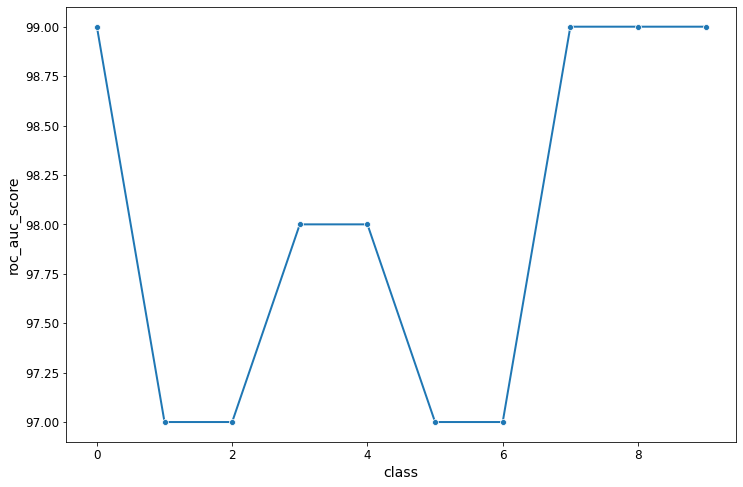

In [59]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(12,8))
_data = df_seq_cr[df_seq_cr.roc_auc_score!='']
_data.loc[:,'roc_auc_score'] = _data.loc[:,'roc_auc_score'].apply(lambda x:x*100).astype(int)
_data = _data.reset_index()
_data.rename(columns={'index':'class'}, inplace=True)
palette = sns.color_palette("bright", 10)
ax = sns.lineplot(data=_data, x="class", y="roc_auc_score",  marker='o', palette='tab10', linewidth='2')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Confusion Matrix

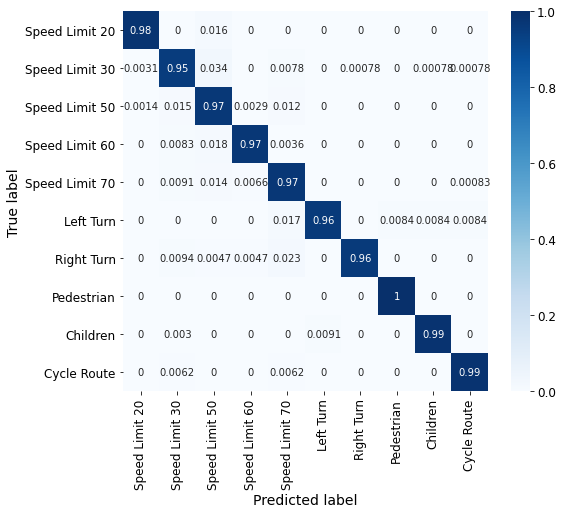

In [60]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_class).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=5)
con_mat_df = pd.DataFrame(con_mat_norm,index = class_names, columns = class_names)
con_mat_df
figure = plt.figure(figsize=(8, 7))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### TP, TN, FP, FN

In [61]:
df_seq_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, y_pred_class))
df_seq_cm.columns=class_names
df_seq_cm.index = class_names
df_seq_cm

,Speed Limit 20,Speed Limit 30,Speed Limit 50,Speed Limit 60,Speed Limit 70,Left Turn,Right Turn,Pedestrian,Children,Cycle Route
Speed Limit 20,122,0,2,0,0,0,0,0,0,0
Speed Limit 30,4,1215,43,0,10,0,1,0,1,1
Speed Limit 50,2,21,1342,4,17,0,0,0,0,0
Speed Limit 60,0,7,15,814,3,0,0,0,0,0
Speed Limit 70,0,11,17,8,1174,0,0,0,0,1
Left Turn,0,0,0,0,2,114,0,1,1,1
Right Turn,0,2,1,1,5,0,205,0,0,0
Pedestrian,0,0,0,0,0,0,0,155,0,0
Children,0,1,0,0,0,3,0,0,325,0
Cycle Route,0,1,0,0,1,0,0,0,0,160


<AxesSubplot:title={'center':'Confusion Matrix (TP, TN, FP, FN)'}>

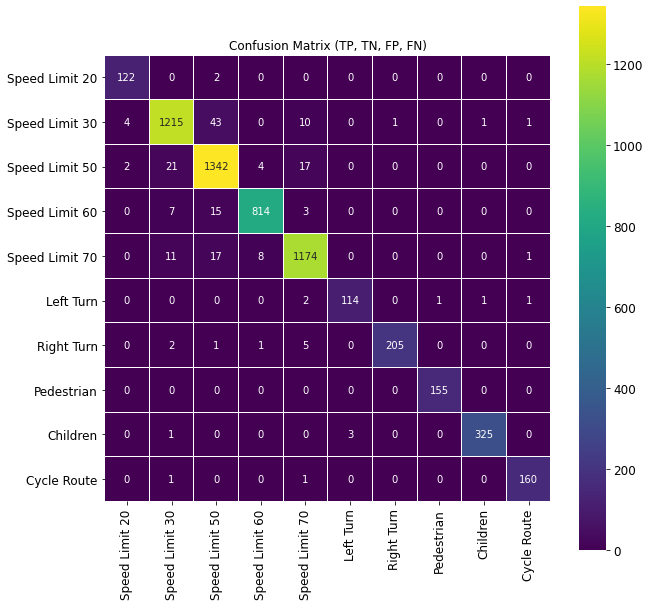

In [62]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Confusion Matrix (TP, TN, FP, FN)')
sns.heatmap(df_seq_cm, 
            cmap="viridis",
            fmt=".0f",
            annot_kws={"fontsize":10},
            square=True,
            annot=True,
           linewidths=.01,
           ax=ax)

### Grid Search

In [63]:
model = KerasClassifier(build_fn=f_ModelGridSearch, verbose=1)
optimizers = ['adam']
# init = ['glorot_uniform', 'normal', 'uniform']
init = ['glorot_uniform']
epochs = ar_of_epochs

param_grid = dict(optimizer=optimizers, epochs=epochs, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    verbose=1,
                    return_train_score=True,
                    n_jobs=2)

In [64]:
grid_result = grid.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  3.8min finished


Epoch 1/40
303/303 [==============================] - 0s 1ms/step - loss: 1.5023 - accuracy: 0.4710
Epoch 2/40
303/303 [==============================] - 0s 2ms/step - loss: 1.0181 - accuracy: 0.6854
Epoch 3/40
303/303 [==============================] - 0s 2ms/step - loss: 0.7708 - accuracy: 0.7819
Epoch 4/40
303/303 [==============================] - 0s 2ms/step - loss: 0.6138 - accuracy: 0.8336
Epoch 5/40
303/303 [==============================] - 0s 1ms/step - loss: 0.5114 - accuracy: 0.8613
Epoch 6/40
303/303 [==============================] - 1s 2ms/step - loss: 0.4317 - accuracy: 0.8837: 0s - loss: 0.418
Epoch 7/40
303/303 [==============================] - 1s 2ms/step - loss: 0.3778 - accuracy: 0.8986
Epoch 8/40
303/303 [==============================] - 0s 1ms/step - loss: 0.3488 - accuracy: 0.9032
Epoch 9/40
303/303 [==============================] - 0s 1ms/step - loss: 0.3192 - accuracy: 0.9157
Epoch 10/40
303/303 [==============================] - 0s 1ms/step - loss: 0.2892 

In [65]:
gr_results = grid_result.cv_results_

In [66]:
scores_df = pd.DataFrame(gr_results).sort_values(by=['param_epochs','param_init'])
scores_df = scores_df.drop(['params'], axis=1)
scores_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_init,param_optimizer,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.428012,0.055621,0.519800,0.099278,1,glorot_uniform,adam,0.196078,0.227554,0.154799,0.029928,0.098555,0.141383,0.070503,6,0.639835,0.628096,0.633256,0.583462,0.595201,0.615970,0.022376
1,6.649193,0.394371,0.785601,0.223647,10,glorot_uniform,adam,0.555728,0.819401,0.622807,0.540248,0.154283,0.538493,0.216304,4,0.956140,0.930470,0.932921,0.919763,0.931889,0.934236,0.011922
2,11.959198,0.528093,0.806198,0.125555,20,glorot_uniform,adam,0.514448,0.648091,0.675439,0.567595,0.150155,0.511146,0.189345,5,0.973555,0.961171,0.958849,0.964138,0.937177,0.958978,0.011993
3,16.328143,0.605176,0.652597,0.108778,30,glorot_uniform,adam,0.708978,0.621775,0.688339,0.663055,0.155831,0.567595,0.207926,3,0.978070,0.959623,0.968137,0.979102,0.932018,0.963390,0.017224
4,19.454776,0.440047,0.609399,0.057769,40,glorot_uniform,adam,0.641899,0.818885,0.681631,0.724974,0.153251,0.604128,0.233001,1,0.992002,0.984649,0.987100,0.971878,0.980521,0.983230,0.006784
5,25.722867,2.486828,0.644802,0.229929,50,glorot_uniform,adam,0.583075,0.647575,0.839525,0.639319,0.158927,0.573684,0.224745,2,0.995356,0.985165,0.947497,0.986713,0.975103,0.977967,0.016537


In [67]:
scores_df_gp = scores_df.groupby(['param_epochs'], as_index=False).agg({'mean_test_score':'sum','mean_train_score':'sum'})
scores_df_gp

,param_epochs,mean_test_score,mean_train_score
0,1,0.141383,0.615970
1,10,0.538493,0.934236
2,20,0.511146,0.958978
3,30,0.567595,0.963390
4,40,0.604128,0.983230
5,50,0.573684,0.977967


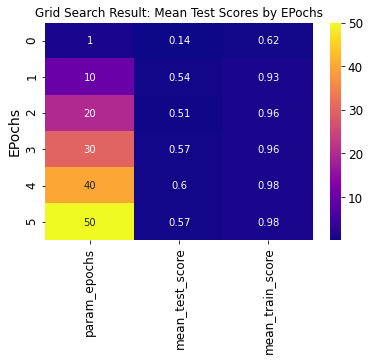

In [68]:
sns.heatmap(scores_df_gp, annot=True, cmap='plasma')
plt.title('Grid Search Result: Mean Test Scores by EPochs');
plt.ylabel('EPochs');

## Question No. 5

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.93, random_state=no_of_seeds)
print('X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)

X_train (678, 784) X_test (9012, 784) y_train (678, 1) y_test (9012, 1)


### Model Evaluation

In [70]:
if os.path.exists("logs/fit/seq/") : shutil.rmtree("logs/fit/seq/")
model_seq = f_createModel()
model_seq.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_seq.fit(X.to_numpy()[train], y.to_numpy()[train], epochs=no_of_epochs, validation_data=(X.to_numpy()[test], y.to_numpy()[test]))

log_dir = "logs/fit/seq/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
es_callback = EarlyStopping(monitor='loss', patience=3) # This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs
model_seq.fit(x=X_train, 
              y=y_train, 
              epochs=no_of_epochs, 
              verbose=0,
              callbacks=[tensorboard_callback,es_callback],
              validation_data=(X_test, y_test),
             )
test_loss, test_acc = model_seq.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy:', test_acc)
# %reload_ext tensorboard
# %tensorboard --logdir logs/fit/seq/ --host localhost --port 8088
# Launch http://localhost:8088/

Epoch 1/30
273/273 [==============================] - 1s 2ms/step - loss: 1.5183 - accuracy: 0.4727 - val_loss: 1.1771 - val_accuracy: 0.6058
Epoch 2/30
273/273 [==============================] - 0s 2ms/step - loss: 1.0543 - accuracy: 0.6722 - val_loss: 0.9297 - val_accuracy: 0.7224
Epoch 3/30
273/273 [==============================] - 1s 2ms/step - loss: 0.8222 - accuracy: 0.7561 - val_loss: 0.7994 - val_accuracy: 0.7554
Epoch 4/30
273/273 [==============================] - 1s 2ms/step - loss: 0.6666 - accuracy: 0.8069 - val_loss: 0.5992 - val_accuracy: 0.8411
Epoch 5/30
273/273 [==============================] - 0s 2ms/step - loss: 0.5681 - accuracy: 0.8394 - val_loss: 0.7736 - val_accuracy: 0.7554
Epoch 6/30
273/273 [==============================] - 1s 2ms/step - loss: 0.4902 - accuracy: 0.8641 - val_loss: 0.4739 - val_accuracy: 0.8720
Epoch 7/30
273/273 [==============================] - 0s 2ms/step - loss: 0.4173 - accuracy: 0.8873 - val_loss: 0.3926 - val_accuracy: 0.9092
Epoch 

#### Accurancy and Loss Plot

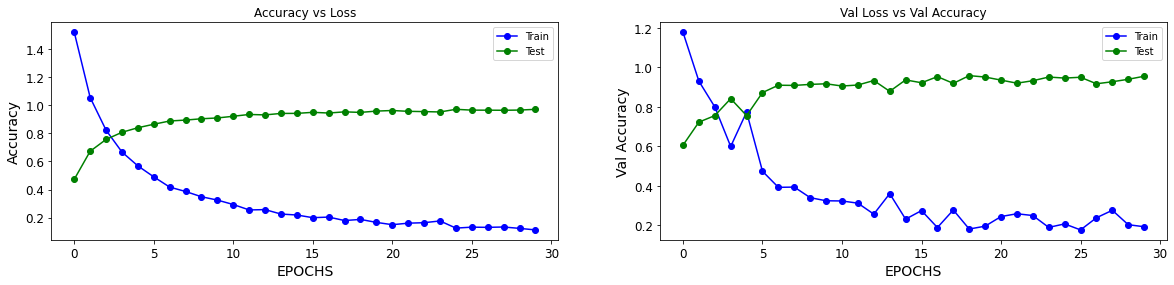

In [71]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,4))
ax1.plot(history.history['loss'], marker='o', label='Train', color='b')
ax1.plot(history.history['accuracy'], marker='o', label='Test', color='g')
ax1.set_title('Accuracy vs Loss')
ax1.set(xlabel='EPOCHS', ylabel='Accuracy')
ax1.legend(loc='upper right')
ax2.plot(history.history['val_loss'], marker='o', label='Train', color='b')
ax2.plot(history.history['val_accuracy'], marker='o', label='Test', color='g')
ax2.set_title('Val Loss vs Val Accuracy')
ax2.set(xlabel='EPOCHS', ylabel='Val Accuracy')
ax2.legend(loc='upper right')

### Predictions

In [72]:
y_predict = model_seq.predict(X_test)
y_pred_class = np.argmax(model_seq.predict(X_test), axis=-1) #predict_classes is depereciated

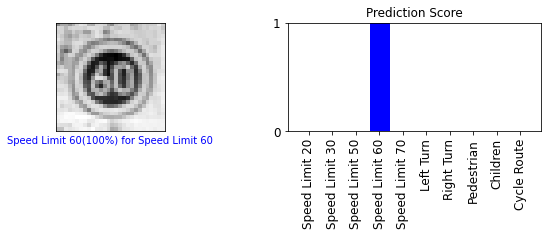

In [73]:
record_pred=15
f_PlotPresentPredictions(record_pred, y_predict[record_pred], y_test, X_test)

### Classification Report

In [74]:
roc_auc_score = f_ROC_AUC_Score_Multiclass(y_test.to_numpy().ravel(),y_pred_class)

In [75]:
roc_auc_score['accuracy']=''
roc_auc_score['macro avg']=''
roc_auc_score['weighted avg']=''
np_roc = []
for key, value in roc_auc_score.items():
    np_roc.append(value)

In [76]:
_classification_report = sklearn.metrics.classification_report(y_test, y_pred_class, output_dict=True)
df_seq_cr = pd.DataFrame(_classification_report).transpose()
df_seq_cr.loc['accuracy','precision']=''
df_seq_cr.loc['accuracy','recall']=''
df_seq_cr['roc_auc_score'] = np_roc
df_seq_cr

,precision,recall,f1-score,support,roc_auc_score
0,0.954545,0.989529,0.971722,191.000000,0.994254
1,0.971084,0.97343,0.972256,2070.000000,0.982393
2,0.970851,0.977283,0.974057,2113.000000,0.984148
3,0.990805,0.98327,0.987023,1315.000000,0.990855
4,0.985099,0.977547,0.981308,1826.000000,0.986895
5,0.964467,1,0.981912,190.000000,0.999603
6,0.98806,0.98806,0.988060,335.000000,0.993799
7,1,0.99095,0.995455,221.000000,0.995475
8,0.997984,0.991984,0.994975,499.000000,0.995933
9,0.995968,0.980159,0.988000,252.000000,0.990022


In [77]:
df_seq_cr.reset_index(inplace=True)
df_seq_cr = df_seq_cr.rename(columns = {'index':'Measure','f1-score':'f1_score'})
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='0', class_names[0], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='1', class_names[1], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='2', class_names[2], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='3', class_names[3], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='4', class_names[4], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='5', class_names[5], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='6', class_names[6], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='7', class_names[7], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='8', class_names[8], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='9', class_names[9], df_seq_cr['Measure'])
df_seq_cr

,Measure,precision,recall,f1_score,support,roc_auc_score
0,Speed Limit 20,0.954545,0.989529,0.971722,191.000000,0.994254
1,Speed Limit 30,0.971084,0.97343,0.972256,2070.000000,0.982393
2,Speed Limit 50,0.970851,0.977283,0.974057,2113.000000,0.984148
3,Speed Limit 60,0.990805,0.98327,0.987023,1315.000000,0.990855
4,Speed Limit 70,0.985099,0.977547,0.981308,1826.000000,0.986895
5,Left Turn,0.964467,1,0.981912,190.000000,0.999603
6,Right Turn,0.98806,0.98806,0.988060,335.000000,0.993799
7,Pedestrian,1,0.99095,0.995455,221.000000,0.995475
8,Children,0.997984,0.991984,0.994975,499.000000,0.995933
9,Cycle Route,0.995968,0.980159,0.988000,252.000000,0.990022


### ROC AUC Score Plot

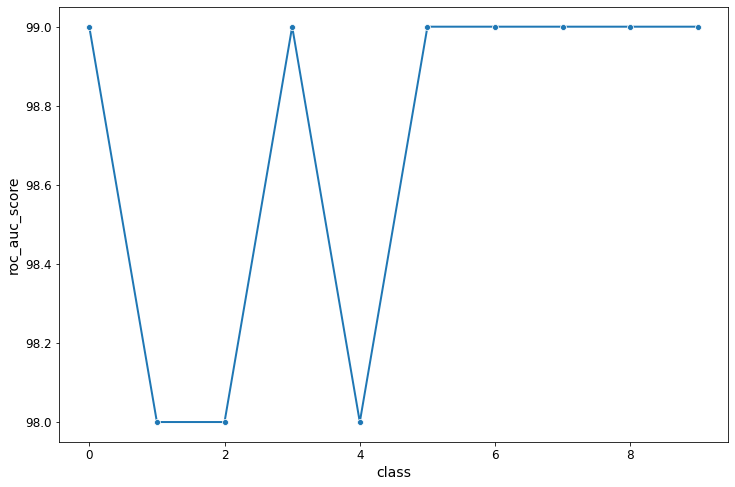

In [78]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(12,8))
_data = df_seq_cr[df_seq_cr.roc_auc_score!='']
_data.loc[:,'roc_auc_score'] = _data.loc[:,'roc_auc_score'].apply(lambda x:x*100).astype(int)
_data = _data.reset_index()
_data.rename(columns={'index':'class'}, inplace=True)
palette = sns.color_palette("bright", 10)
ax = sns.lineplot(data=_data, x="class", y="roc_auc_score",  marker='o', palette='tab10', linewidth='2')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Confusion Matrix

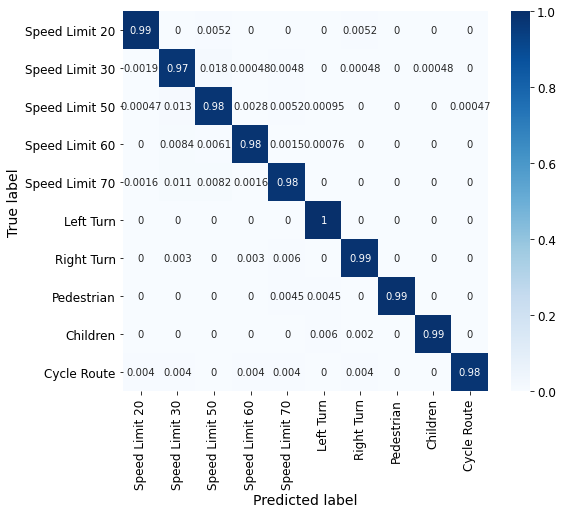

In [79]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_class).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=5)
con_mat_df = pd.DataFrame(con_mat_norm,index = class_names, columns = class_names)
con_mat_df
figure = plt.figure(figsize=(8, 7))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### TP, TN, FP, FN

In [80]:
df_seq_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, y_pred_class))
df_seq_cm.columns=class_names
df_seq_cm.index = class_names
df_seq_cm

,Speed Limit 20,Speed Limit 30,Speed Limit 50,Speed Limit 60,Speed Limit 70,Left Turn,Right Turn,Pedestrian,Children,Cycle Route
Speed Limit 20,189,0,1,0,0,0,1,0,0,0
Speed Limit 30,4,2015,38,1,10,0,1,0,1,0
Speed Limit 50,1,27,2065,6,11,2,0,0,0,1
Speed Limit 60,0,11,8,1293,2,1,0,0,0,0
Speed Limit 70,3,20,15,3,1785,0,0,0,0,0
Left Turn,0,0,0,0,0,190,0,0,0,0
Right Turn,0,1,0,1,2,0,331,0,0,0
Pedestrian,0,0,0,0,1,1,0,219,0,0
Children,0,0,0,0,0,3,1,0,495,0
Cycle Route,1,1,0,1,1,0,1,0,0,247


<AxesSubplot:title={'center':'Confusion Matrix (TP, TN, FP, FN)'}>

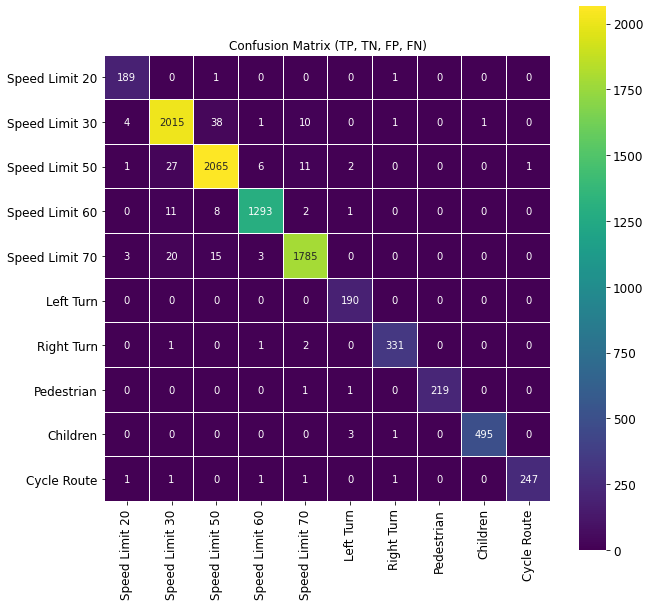

In [81]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Confusion Matrix (TP, TN, FP, FN)')
sns.heatmap(df_seq_cm, 
            cmap="viridis",
            fmt=".0f",
            annot_kws={"fontsize":10},
            square=True,
            annot=True,
           linewidths=.01,
           ax=ax)

### Grid Search

In [82]:
model = KerasClassifier(build_fn=f_ModelGridSearch, verbose=1)
optimizers = ['adam']
# init = ['glorot_uniform', 'normal', 'uniform']
init = ['glorot_uniform']
epochs = ar_of_epochs

param_grid = dict(optimizer=optimizers, epochs=epochs, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    verbose=1,
                    return_train_score=True,
                    n_jobs=2)

In [83]:
grid_result = grid.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  3.6min finished


Epoch 1/40
303/303 [==============================] - 0s 1ms/step - loss: 1.4907 - accuracy: 0.4706
Epoch 2/40
303/303 [==============================] - 0s 2ms/step - loss: 1.0262 - accuracy: 0.6907
Epoch 3/40
303/303 [==============================] - 0s 1ms/step - loss: 0.7779 - accuracy: 0.7764
Epoch 4/40
303/303 [==============================] - 0s 2ms/step - loss: 0.6198 - accuracy: 0.8249
Epoch 5/40
303/303 [==============================] - 1s 2ms/step - loss: 0.5067 - accuracy: 0.8593
Epoch 6/40
303/303 [==============================] - 0s 2ms/step - loss: 0.4443 - accuracy: 0.8760
Epoch 7/40
303/303 [==============================] - 0s 1ms/step - loss: 0.3810 - accuracy: 0.8992
Epoch 8/40
303/303 [==============================] - 0s 1ms/step - loss: 0.3596 - accuracy: 0.9012
Epoch 9/40
303/303 [==============================] - 0s 1ms/step - loss: 0.3298 - accuracy: 0.9111
Epoch 10/40
303/303 [==============================] - 0s 1ms/step - loss: 0.3083 - accuracy: 0.9146

In [84]:
gr_results = grid_result.cv_results_

In [85]:
scores_df = pd.DataFrame(gr_results).sort_values(by=['param_epochs','param_init'])
scores_df = scores_df.drop(['params'], axis=1)
scores_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_init,param_optimizer,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.177924,0.156521,0.417812,0.056985,1,glorot_uniform,adam,0.200722,0.325593,0.276058,0.062951,0.111455,0.195356,0.098055,6,0.611326,0.590041,0.550568,0.597652,0.642157,0.598349,0.029800
1,5.249398,0.337500,0.590200,0.060521,10,glorot_uniform,adam,0.435501,0.679567,0.417957,0.503612,0.155831,0.438493,0.168929,5,0.948916,0.938080,0.883901,0.932534,0.920666,0.924819,0.022395
2,10.076849,0.295569,0.581802,0.071837,20,glorot_uniform,adam,0.624871,0.736326,0.761610,0.644995,0.136223,0.580805,0.228295,2,0.975361,0.972910,0.966718,0.968395,0.928406,0.962358,0.017255
3,14.800660,0.263086,0.549402,0.064698,30,glorot_uniform,adam,0.575851,0.746130,0.636739,0.572239,0.156347,0.537461,0.200664,4,0.988261,0.980134,0.960397,0.978070,0.976651,0.976703,0.009090
4,20.542470,1.239160,0.637000,0.051381,40,glorot_uniform,adam,0.606295,0.754902,0.755418,0.652735,0.141383,0.582147,0.227906,1,0.973555,0.980134,0.988390,0.977812,0.951109,0.974200,0.012516
5,25.621585,1.899305,0.632907,0.147975,50,glorot_uniform,adam,0.574819,0.728070,0.736842,0.688855,0.150671,0.575851,0.220290,3,0.990970,0.971749,0.979618,0.981811,0.957817,0.976393,0.011125


In [86]:
scores_df_gp = scores_df.groupby(['param_epochs'], as_index=False).agg({'mean_test_score':'sum','mean_train_score':'sum'})
scores_df_gp

,param_epochs,mean_test_score,mean_train_score
0,1,0.195356,0.598349
1,10,0.438493,0.924819
2,20,0.580805,0.962358
3,30,0.537461,0.976703
4,40,0.582147,0.974200
5,50,0.575851,0.976393


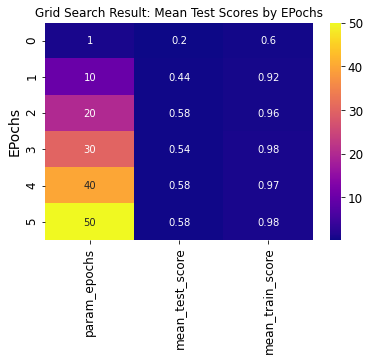

In [87]:
sns.heatmap(scores_df_gp, annot=True, cmap='plasma')
plt.title('Grid Search Result: Mean Test Scores by EPochs');
plt.ylabel('EPochs');

# Part 2 - CNN

## Q1 - K10 Folds Cross Validation

In [88]:
XX = X.to_numpy().reshape(9690,_image_resize,_image_resize,1)
print('New X',XX.shape,'Y',y.shape)

New X (9690, 28, 28, 1) Y (9690, 1)


In [89]:
kf = KFold(n_splits = no_of_folds)
skf = StratifiedKFold(n_splits=no_of_folds, shuffle=True, random_state=no_of_seeds)

In [90]:
kfolds_cvs = [] #Cross Validation Scores
kfolds_counter = 0
kfolds_cr  = {}  #Classification Report
kfolds_roc = {}  #For ROC and AUC Scores
kfolds_cm  = []  #Confusion Matrix 
kfolds_hist= {}  #Stores the Model History

for train, test in skf.split(XX, y):
    _model_cnn = f_createCNNModel()
    _model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy','mean_squared_error'])
    kfolds_hist[kfolds_counter+1] = _model_cnn.fit(XX[train], y.to_numpy()[train], epochs=no_of_epochs, validation_data=(XX[test], y.to_numpy()[test]))
        
    _model_cnn.fit(XX[train], y.to_numpy()[train], epochs=no_of_epochs)
    _scores = _model_cnn.evaluate(XX[test], y.to_numpy()[test], verbose=1)
    _y_pred_class = np.argmax(_model_cnn.predict(XX[test]),axis=-1)
    
    kfolds_roc[kfolds_counter] = f_ROC_AUC_Score_Multiclass(y.to_numpy()[test].ravel(), _y_pred_class)
    kfolds_cr[kfolds_counter] = sklearn.metrics.classification_report(y.to_numpy()[test], _y_pred_class, output_dict=True, zero_division=0)
    
    for key, value in kfolds_cr.items():
        for i_k, i_v in kfolds_cr[key].items():
            if type(kfolds_cr[key][i_k])==dict:
                kfolds_cr[key][i_k]['folds'] = int(key+1)

    kfolds_cm.append(sklearn.metrics.confusion_matrix(y.to_numpy()[test], _y_pred_class))
    kfolds_cvs.append(_scores[1] * 100)
    kfolds_counter+=1

Epoch 1/30
273/273 [==============================] - 10s 38ms/step - loss: 1.3503 - accuracy: 0.5082 - mean_squared_error: 14.0562 - val_loss: 0.5597 - val_accuracy: 0.8184 - val_mean_squared_error: 14.0839
Epoch 2/30
273/273 [==============================] - 10s 35ms/step - loss: 0.3120 - accuracy: 0.9117 - mean_squared_error: 14.1003 - val_loss: 0.2359 - val_accuracy: 0.9391 - val_mean_squared_error: 14.1028
Epoch 3/30
273/273 [==============================] - 10s 36ms/step - loss: 0.1362 - accuracy: 0.9650 - mean_squared_error: 14.1126 - val_loss: 0.0864 - val_accuracy: 0.9783 - val_mean_squared_error: 14.1153
Epoch 4/30
273/273 [==============================] - 10s 35ms/step - loss: 0.0826 - accuracy: 0.9788 - mean_squared_error: 14.1167 - val_loss: 0.1156 - val_accuracy: 0.9639 - val_mean_squared_error: 14.1155
Epoch 5/30
273/273 [==============================] - 9s 35ms/step - loss: 0.0571 - accuracy: 0.9859 - mean_squared_error: 14.1186 - val_loss: 0.0440 - val_accuracy: 0.

273/273 [==============================] - 10s 36ms/step - loss: 0.0263 - accuracy: 0.9914 - mean_squared_error: 14.1220 - val_loss: 0.0422 - val_accuracy: 0.9917 - val_mean_squared_error: 14.1225
Epoch 29/30
273/273 [==============================] - 10s 36ms/step - loss: 0.0093 - accuracy: 0.9981 - mean_squared_error: 14.1228 - val_loss: 0.0350 - val_accuracy: 0.9959 - val_mean_squared_error: 14.1229
Epoch 30/30
273/273 [==============================] - 10s 36ms/step - loss: 8.7865e-04 - accuracy: 1.0000 - mean_squared_error: 14.1234 - val_loss: 0.0373 - val_accuracy: 0.9948 - val_mean_squared_error: 14.1230
Epoch 1/30
273/273 [==============================] - 9s 33ms/step - loss: 5.1167e-04 - accuracy: 1.0000 - mean_squared_error: 14.1234
Epoch 2/30
273/273 [==============================] - 10s 35ms/step - loss: 3.7691e-04 - accuracy: 1.0000 - mean_squared_error: 14.1235
Epoch 3/30
273/273 [==============================] - 10s 36ms/step - loss: 3.0443e-04 - accuracy: 1.0000 - me

273/273 [==============================] - 10s 36ms/step - loss: 0.1234 - accuracy: 0.9670 - mean_squared_error: 14.1140 - val_loss: 0.1099 - val_accuracy: 0.9701 - val_mean_squared_error: 14.1137
Epoch 4/30
273/273 [==============================] - 10s 37ms/step - loss: 0.0727 - accuracy: 0.9825 - mean_squared_error: 14.1174 - val_loss: 0.0767 - val_accuracy: 0.9711 - val_mean_squared_error: 14.1177
Epoch 5/30
273/273 [==============================] - 9s 35ms/step - loss: 0.0532 - accuracy: 0.9872 - mean_squared_error: 14.1191 - val_loss: 0.0524 - val_accuracy: 0.9856 - val_mean_squared_error: 14.1196
Epoch 6/30
273/273 [==============================] - 9s 34ms/step - loss: 0.0289 - accuracy: 0.9944 - mean_squared_error: 14.1207 - val_loss: 0.0869 - val_accuracy: 0.9721 - val_mean_squared_error: 14.1197
Epoch 7/30
273/273 [==============================] - 10s 36ms/step - loss: 0.0499 - accuracy: 0.9859 - mean_squared_error: 14.1202 - val_loss: 0.1040 - val_accuracy: 0.9721 - val_m

273/273 [==============================] - 9s 33ms/step - loss: 0.0512 - accuracy: 0.9862 - mean_squared_error: 14.1215 - val_loss: 0.0412 - val_accuracy: 0.9876 - val_mean_squared_error: 14.1218
Epoch 30/30
273/273 [==============================] - 9s 33ms/step - loss: 0.0180 - accuracy: 0.9950 - mean_squared_error: 14.1225 - val_loss: 0.0321 - val_accuracy: 0.9917 - val_mean_squared_error: 14.1226
Epoch 1/30
273/273 [==============================] - 9s 33ms/step - loss: 0.0031 - accuracy: 0.9992 - mean_squared_error: 14.1232
Epoch 2/30
273/273 [==============================] - 9s 31ms/step - loss: 8.4082e-04 - accuracy: 1.0000 - mean_squared_error: 14.1234
Epoch 3/30
273/273 [==============================] - 10s 36ms/step - loss: 4.3060e-04 - accuracy: 1.0000 - mean_squared_error: 14.1235
Epoch 4/30
273/273 [==============================] - 9s 31ms/step - loss: 3.1916e-04 - accuracy: 1.0000 - mean_squared_error: 14.1235
Epoch 5/30
273/273 [==============================] - 9s 32

273/273 [==============================] - 10s 36ms/step - loss: 0.0390 - accuracy: 0.9904 - mean_squared_error: 14.1202 - val_loss: 0.0878 - val_accuracy: 0.9721 - val_mean_squared_error: 14.1183
Epoch 7/30
273/273 [==============================] - 9s 35ms/step - loss: 0.0247 - accuracy: 0.9937 - mean_squared_error: 14.1211 - val_loss: 0.0395 - val_accuracy: 0.9886 - val_mean_squared_error: 14.1211
Epoch 8/30
273/273 [==============================] - 9s 35ms/step - loss: 0.0474 - accuracy: 0.9870 - mean_squared_error: 14.1205 - val_loss: 0.0369 - val_accuracy: 0.9835 - val_mean_squared_error: 14.1212
Epoch 9/30
273/273 [==============================] - 10s 35ms/step - loss: 0.0134 - accuracy: 0.9968 - mean_squared_error: 14.1222 - val_loss: 0.0265 - val_accuracy: 0.9938 - val_mean_squared_error: 14.1220
Epoch 10/30
273/273 [==============================] - 9s 35ms/step - loss: 0.0085 - accuracy: 0.9984 - mean_squared_error: 14.1225 - val_loss: 0.0324 - val_accuracy: 0.9886 - val_m

273/273 [==============================] - 10s 35ms/step - loss: 4.8296e-05 - accuracy: 1.0000 - mean_squared_error: 14.1235
Epoch 6/30
273/273 [==============================] - 9s 35ms/step - loss: 4.2106e-05 - accuracy: 1.0000 - mean_squared_error: 14.1235
Epoch 7/30
273/273 [==============================] - 9s 35ms/step - loss: 3.6656e-05 - accuracy: 1.0000 - mean_squared_error: 14.1235
Epoch 8/30
273/273 [==============================] - 10s 35ms/step - loss: 3.6693e-05 - accuracy: 1.0000 - mean_squared_error: 14.1235
Epoch 9/30
273/273 [==============================] - 9s 34ms/step - loss: 4.0626e-05 - accuracy: 1.0000 - mean_squared_error: 14.1235
Epoch 10/30
273/273 [==============================] - 9s 34ms/step - loss: 2.4974e-05 - accuracy: 1.0000 - mean_squared_error: 14.1235
Epoch 11/30
273/273 [==============================] - 10s 35ms/step - loss: 2.4965e-05 - accuracy: 1.0000 - mean_squared_error: 14.1235
Epoch 12/30
273/273 [==============================] - 9s 35m

Epoch 23/30
273/273 [==============================] - 8s 30ms/step - loss: 6.5563e-04 - accuracy: 1.0000 - mean_squared_error: 14.1234 - val_loss: 0.0126 - val_accuracy: 0.9959 - val_mean_squared_error: 14.1231
Epoch 24/30
273/273 [==============================] - 9s 32ms/step - loss: 4.3849e-04 - accuracy: 1.0000 - mean_squared_error: 14.1234 - val_loss: 0.0122 - val_accuracy: 0.9969 - val_mean_squared_error: 14.1231
Epoch 25/30
273/273 [==============================] - 9s 33ms/step - loss: 3.6727e-04 - accuracy: 1.0000 - mean_squared_error: 14.1235 - val_loss: 0.0128 - val_accuracy: 0.9969 - val_mean_squared_error: 14.1231
Epoch 26/30
273/273 [==============================] - 9s 32ms/step - loss: 2.9077e-04 - accuracy: 1.0000 - mean_squared_error: 14.1235 - val_loss: 0.0121 - val_accuracy: 0.9969 - val_mean_squared_error: 14.1232
Epoch 27/30
273/273 [==============================] - 9s 32ms/step - loss: 2.5355e-04 - accuracy: 1.0000 - mean_squared_error: 14.1235 - val_loss: 0.01

273/273 [==============================] - 9s 31ms/step - loss: 0.0026 - accuracy: 0.9993 - mean_squared_error: 14.1232
Epoch 30/30
31/31 [==============================] - 0s 8ms/step - loss: 0.0408 - accuracy: 0.9938 - mean_squared_error: 14.1232


#### Accuracy Plot

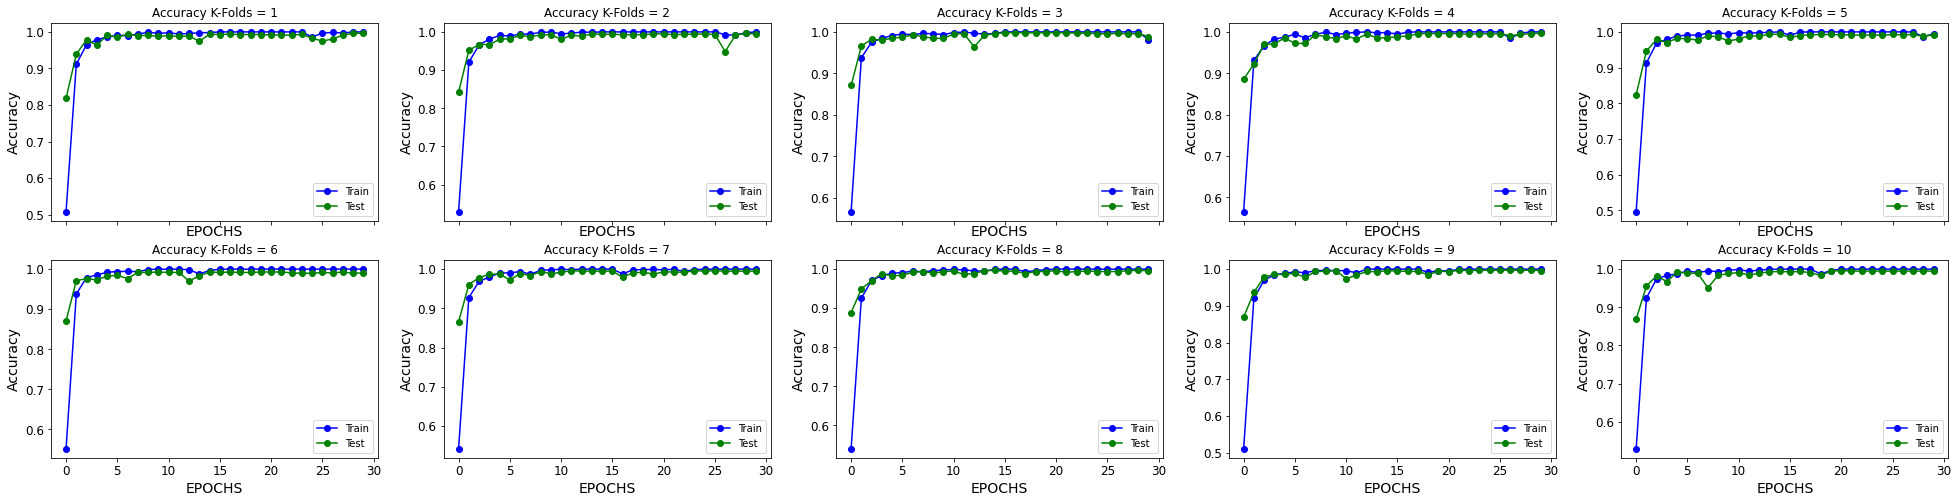

In [91]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(34,8))
for ax, _fold_counter in zip(axes.flatten(), kfolds_hist):
    ax.plot(kfolds_hist[_fold_counter].history['accuracy'], marker='o',label='Train', color='blue')
    ax.plot(kfolds_hist[_fold_counter].history['val_accuracy'], marker='o', label='Test', color='green')
    ax.set_title('Accuracy K-Folds = '+str(_fold_counter))
    ax.set(xlabel='EPOCHS', ylabel='Accuracy')
    ax.legend(loc='lower right')

#### Loss Plot

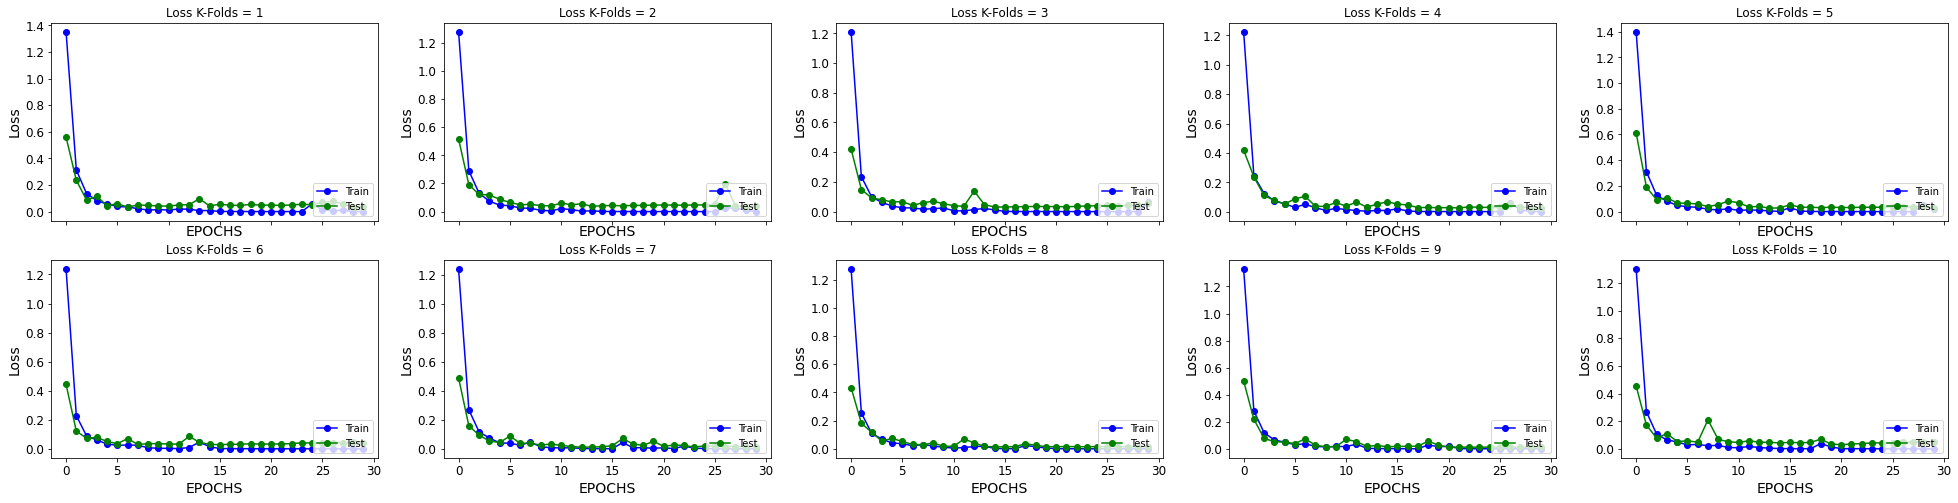

In [92]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(34,8))
for ax, _fold_counter in zip(axes.flatten(), kfolds_hist):
    ax.plot(kfolds_hist[_fold_counter].history['loss'], marker='o',label='Train', color='blue')
    ax.plot(kfolds_hist[_fold_counter].history['val_loss'], marker='o', label='Test', color='green')
    ax.set_title('Loss K-Folds = '+str(_fold_counter))
    ax.set(xlabel='EPOCHS', ylabel='Loss')
    ax.legend(loc='lower right')

#### Mean Squared Error Plot

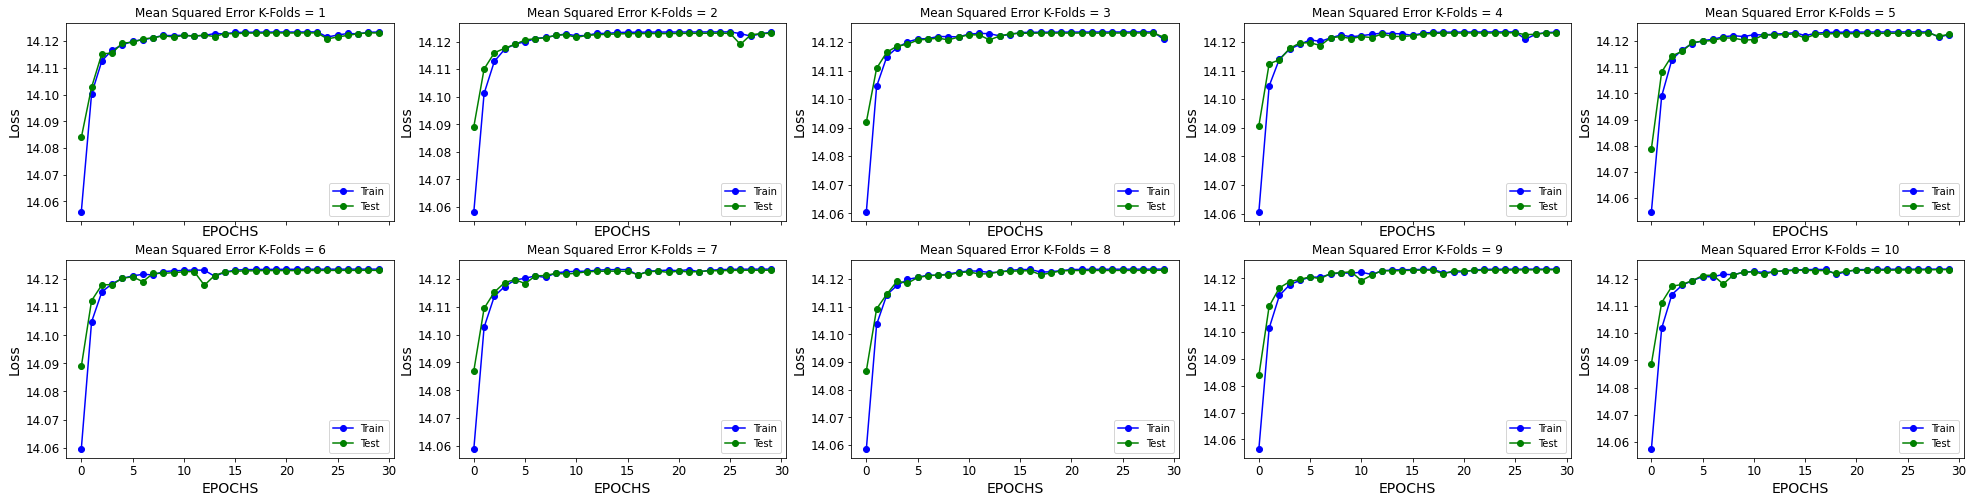

In [93]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(34,8))
for ax, _fold_counter in zip(axes.flatten(), kfolds_hist):
    ax.plot(kfolds_hist[_fold_counter].history['mean_squared_error'], marker='o',label='Train', color='blue')
    ax.plot(kfolds_hist[_fold_counter].history['val_mean_squared_error'], marker='o', label='Test', color='green')
    ax.set_title('Mean Squared Error K-Folds = '+str(_fold_counter))
    ax.set(xlabel='EPOCHS', ylabel='Loss')
    ax.legend(loc='lower right')

### Classification Report K-10 with ROC

In [94]:
np_roc = []
for key, value in kfolds_roc.items():
    kfolds_roc[key]['accuracy']=''
    kfolds_roc[key]['macro avg']=''
    kfolds_roc[key]['weighted avg']=''

for key, value in kfolds_roc.items():
    for i_k, i_v in value.items():
        np_roc.append(i_v)

In [95]:
df_folds_cl_rep = pd.DataFrame()
for folds in range(len(kfolds_cr)):
    df_folds_cl_rep = df_folds_cl_rep.append(pd.DataFrame(kfolds_cr[folds]).transpose(),ignore_index=False)
df_folds_cl_rep.loc['accuracy','precision']=''
df_folds_cl_rep.loc['accuracy','recall']=''
df_folds_cl_rep.loc['accuracy','folds']= np.NAN
df_folds_cl_rep = df_folds_cl_rep.fillna(method='ffill')
df_folds_cl_rep['roc_auc_score']=np_roc

In [96]:
df_folds_cl_rep

,precision,recall,f1-score,support,folds,roc_auc_score
0,1,1,1.000000,21.000000,1.0,1
1,0.986667,1,0.993289,222.000000,1.0,0.997992
2,1,0.991111,0.995536,225.000000,1.0,0.995556
3,0.992908,0.992908,0.992908,141.000000,1.0,0.99585
4,0.994975,1,0.997481,198.000000,1.0,0.999351
5,1,1,1.000000,21.000000,1.0,1
6,1,0.944444,0.971429,36.000000,1.0,0.972222
7,1,1,1.000000,24.000000,1.0,1
8,1,1,1.000000,54.000000,1.0,1
9,1,1,1.000000,27.000000,1.0,1


### ROC AUC Score Plot

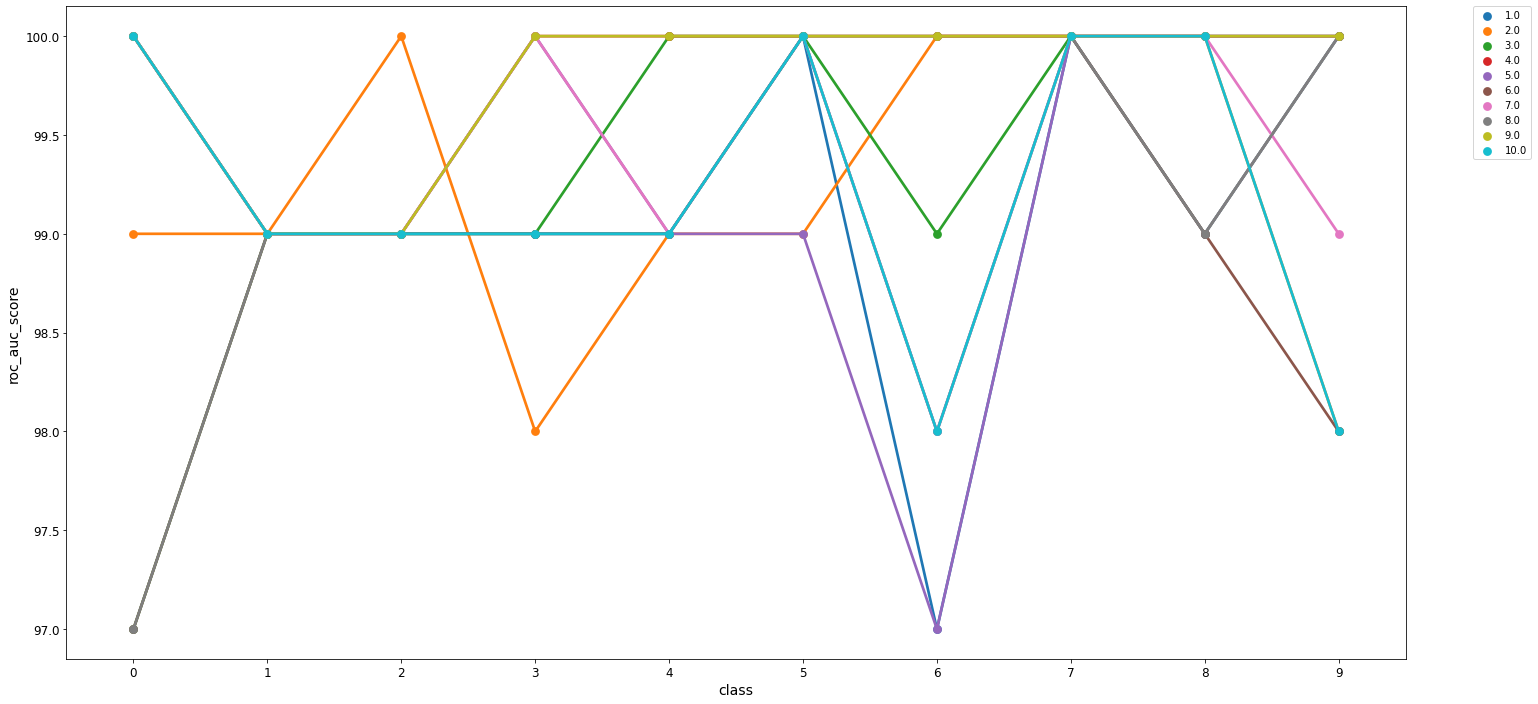

In [97]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(24,12))
_data = df_folds_cl_rep[df_folds_cl_rep.roc_auc_score!='']
_data.loc[:,'roc_auc_score'] = _data.loc[:,'roc_auc_score'].apply(lambda x:x*100).astype(int)
_data = _data.reset_index()
_data.rename(columns={'index':'class'}, inplace=True)
palette = sns.color_palette("bright", 10)
ax = sns.pointplot(data=_data, x="class", y="roc_auc_score", hue='folds', marker='o', legend='full', palette='tab10', linewidth='2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Confusion Matrix K-10

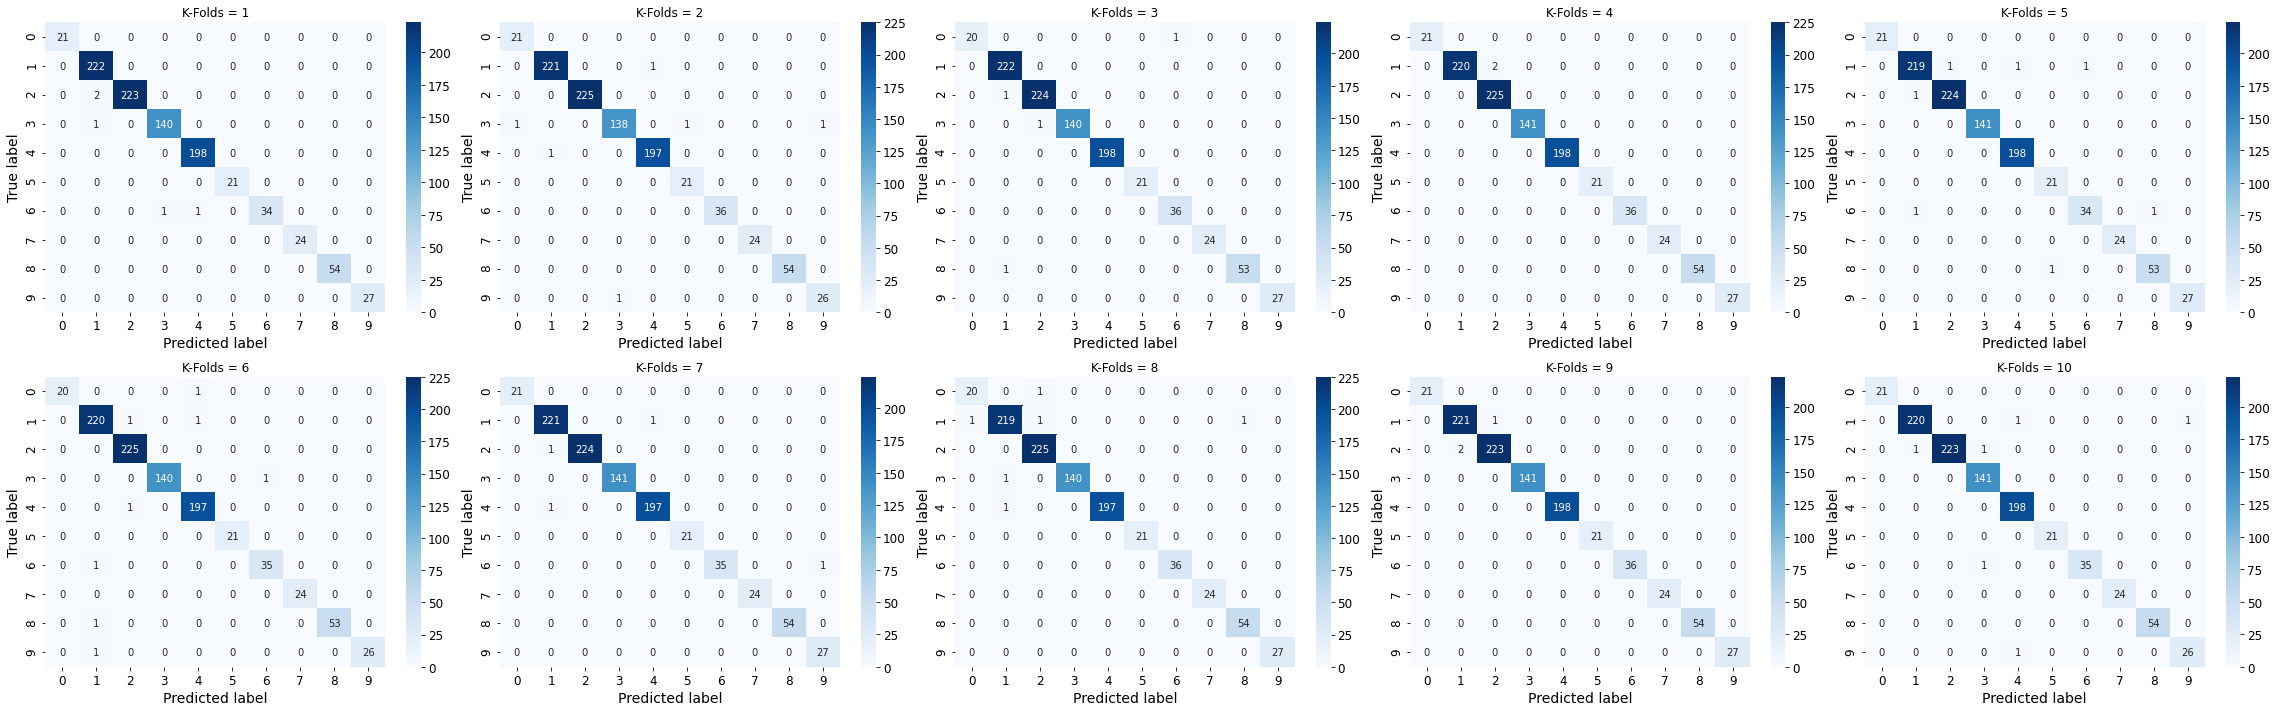

In [98]:
fig, axes = plt.subplots(2,5,figsize=(32,10))
for _fold_counter in range(len(kfolds_cm)):
    row = _fold_counter // 5
    col = _fold_counter % 5
    ax_curr = axes[row, col]
    sns.heatmap(kfolds_cm[_fold_counter], annot=True, cmap=plt.cm.Blues, fmt='g', ax=ax_curr)
    _chart_title = 'K-Folds = '+str(_fold_counter+1)
    ax_curr.set_title(_chart_title)
    ax_curr.set(xlabel='Predicted label', ylabel='True label')
    plt.tight_layout()
#     plt.show()

### Cross Validation Scores

In [99]:
df_folds_cvs = pd.DataFrame(kfolds_cvs)
df_folds_cvs.columns = ['cross_validation_score']
df_folds_cvs['k_folds'] = np.array(range(no_of_folds))
df_folds_cvs['epochs'] = no_of_epochs
df_folds_cvs.sort_values(by=['cross_validation_score'], ascending=False)

,cross_validation_score,k_folds,epochs
3,99.793601,3,30
8,99.690402,8,30
2,99.587202,2,30
6,99.587202,6,30
0,99.484003,0,30
1,99.380803,1,30
7,99.380803,7,30
9,99.380803,9,30
4,99.277604,4,30
5,99.174404,5,30


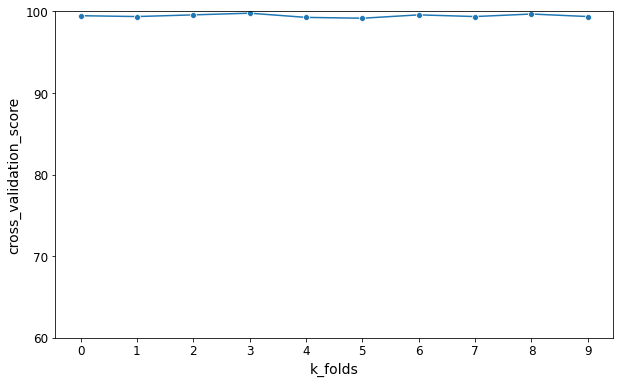

In [100]:
fig, axes = plt.subplots(figsize=(10,6))
ax = sns.lineplot(data=df_folds_cvs, x="k_folds", y="cross_validation_score", marker='o')
ax.set(xticks=df_folds_cvs.k_folds.values)
ax.set(yticks=np.arange(6,11)*10)
plt.show()

In [101]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(kfolds_cvs), np.std(kfolds_cvs)))

99.47% (+/- 0.18%)


## Question No. 3

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=no_of_seeds)
print('X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)
X_train = X_train.to_numpy().reshape(X_train.shape[0],_image_resize,_image_resize,1)
X_test = X_test.to_numpy().reshape(X_test.shape[0],_image_resize,_image_resize,1)
print('X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)

X_train (7752, 784) X_test (1938, 784) y_train (7752, 1) y_test (1938, 1)
X_train (7752, 28, 28, 1) X_test (1938, 28, 28, 1) y_train (7752, 1) y_test (1938, 1)


### Model Evaluation

In [103]:
if os.path.exists("logs/fit/seq/") : shutil.rmtree("logs/fit/seq/")
_model_cnn = f_createCNNModel()
_model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = _model_cnn.fit(X_train, y_train, epochs=no_of_epochs, validation_data=(X_test, y_test))
log_dir = "logs/fit/seq/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es_callback = EarlyStopping(monitor='loss', patience=3) # This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs
_model_cnn.fit(x=X_train, 
              y=y_train, 
              epochs=no_of_epochs, 
              verbose=1, # Suppress chatty output
              callbacks=[tensorboard_callback,es_callback],
              validation_data=(X_test, y_test),
             )
test_loss, test_acc = _model_cnn.evaluate(X_test,  y_test, verbose=0)
print('\nTest accuracy:', test_acc)
# %reload_ext tensorboard
# %tensorboard --logdir logs/fit/seq/
# Launch http://localhost:6006/

Epoch 1/30
243/243 [==============================] - 8s 34ms/step - loss: 1.3258 - accuracy: 0.5092 - val_loss: 0.5361 - val_accuracy: 0.8199
Epoch 2/30
243/243 [==============================] - 7s 30ms/step - loss: 0.2862 - accuracy: 0.9209 - val_loss: 0.1632 - val_accuracy: 0.9515
Epoch 3/30
243/243 [==============================] - 8s 32ms/step - loss: 0.1180 - accuracy: 0.9692 - val_loss: 0.0914 - val_accuracy: 0.9747
Epoch 4/30
243/243 [==============================] - 7s 30ms/step - loss: 0.0688 - accuracy: 0.9834 - val_loss: 0.0672 - val_accuracy: 0.9856
Epoch 5/30
243/243 [==============================] - 8s 32ms/step - loss: 0.0414 - accuracy: 0.9902 - val_loss: 0.0524 - val_accuracy: 0.9881
Epoch 6/30
243/243 [==============================] - 8s 31ms/step - loss: 0.0298 - accuracy: 0.9930 - val_loss: 0.0400 - val_accuracy: 0.9912
Epoch 7/30
243/243 [==============================] - 8s 31ms/step - loss: 0.0272 - accuracy: 0.9932 - val_loss: 0.0468 - val_accuracy: 0.9871

#### Accurancy and Loss Plot

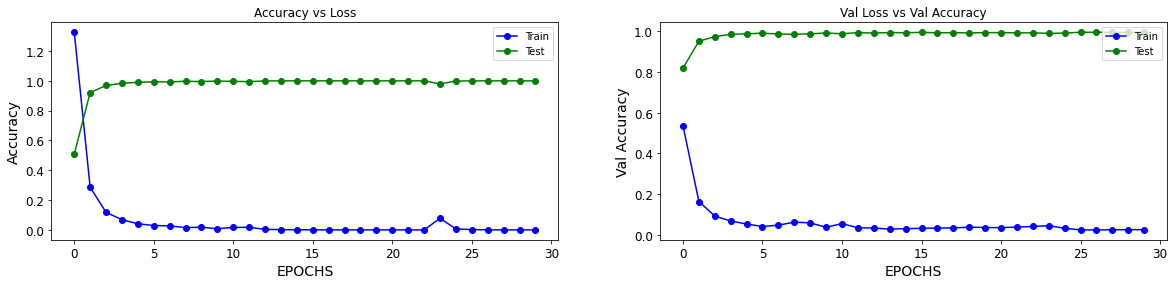

In [104]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,4))
ax1.plot(history.history['loss'], marker='o', label='Train', color='b')
ax1.plot(history.history['accuracy'], marker='o', label='Test', color='g')
ax1.set_title('Accuracy vs Loss')
ax1.set(xlabel='EPOCHS', ylabel='Accuracy')
ax1.legend(loc='upper right')
ax2.plot(history.history['val_loss'], marker='o', label='Train', color='b')
ax2.plot(history.history['val_accuracy'], marker='o', label='Test', color='g')
ax2.set_title('Val Loss vs Val Accuracy')
ax2.set(xlabel='EPOCHS', ylabel='Val Accuracy')
ax2.legend(loc='upper right')

### Predictions

In [105]:
y_predict = _model_cnn.predict(X_test)
y_pred_class = np.argmax(_model_cnn.predict(X_test), axis=-1) #predict_classes is depereciated

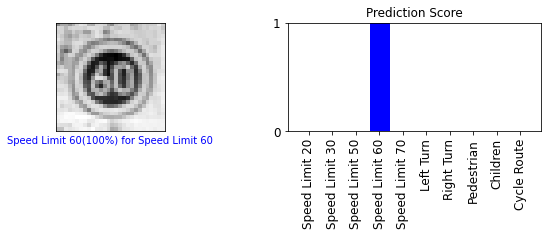

In [106]:
record_pred=15
f_PlotPresentPredictions(record_pred, y_predict[record_pred], y_test, X_test)

### Classification Report

In [107]:
roc_auc_score = f_ROC_AUC_Score_Multiclass(y_test.to_numpy().ravel(),y_pred_class)

In [108]:
roc_auc_score['accuracy']=''
roc_auc_score['macro avg']=''
roc_auc_score['weighted avg']=''
np_roc = []
for key, value in roc_auc_score.items():
    np_roc.append(value)

In [109]:
_classification_report = sklearn.metrics.classification_report(y_test, y_pred_class, output_dict=True)
df_seq_cr = pd.DataFrame(_classification_report).transpose()
df_seq_cr.loc['accuracy','precision']=''
df_seq_cr.loc['accuracy','recall']=''
df_seq_cr['roc_auc_score'] = np_roc
df_seq_cr

,precision,recall,f1-score,support,roc_auc_score
0,0.97619,1,0.987952,41.000000,0.999736
1,0.997696,0.990847,0.994259,437.000000,0.99509
2,0.991011,0.997738,0.994363,442.000000,0.997532
3,0.992481,0.988764,0.990619,267.000000,0.993784
4,0.995249,0.997619,0.996433,420.000000,0.998151
5,1,0.952381,0.975610,42.000000,0.97619
6,1,0.986667,0.993289,75.000000,0.993333
7,1,1,1.000000,50.000000,1
8,0.981982,1,0.990909,109.000000,0.999453
9,1,1,1.000000,55.000000,1


In [110]:
df_seq_cr.reset_index(inplace=True)
df_seq_cr = df_seq_cr.rename(columns = {'index':'Measure','f1-score':'f1_score'})
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='0', class_names[0], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='1', class_names[1], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='2', class_names[2], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='3', class_names[3], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='4', class_names[4], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='5', class_names[5], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='6', class_names[6], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='7', class_names[7], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='8', class_names[8], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='9', class_names[9], df_seq_cr['Measure'])
df_seq_cr

,Measure,precision,recall,f1_score,support,roc_auc_score
0,Speed Limit 20,0.97619,1,0.987952,41.000000,0.999736
1,Speed Limit 30,0.997696,0.990847,0.994259,437.000000,0.99509
2,Speed Limit 50,0.991011,0.997738,0.994363,442.000000,0.997532
3,Speed Limit 60,0.992481,0.988764,0.990619,267.000000,0.993784
4,Speed Limit 70,0.995249,0.997619,0.996433,420.000000,0.998151
5,Left Turn,1,0.952381,0.975610,42.000000,0.97619
6,Right Turn,1,0.986667,0.993289,75.000000,0.993333
7,Pedestrian,1,1,1.000000,50.000000,1
8,Children,0.981982,1,0.990909,109.000000,0.999453
9,Cycle Route,1,1,1.000000,55.000000,1


### ROC AUC Score Plot

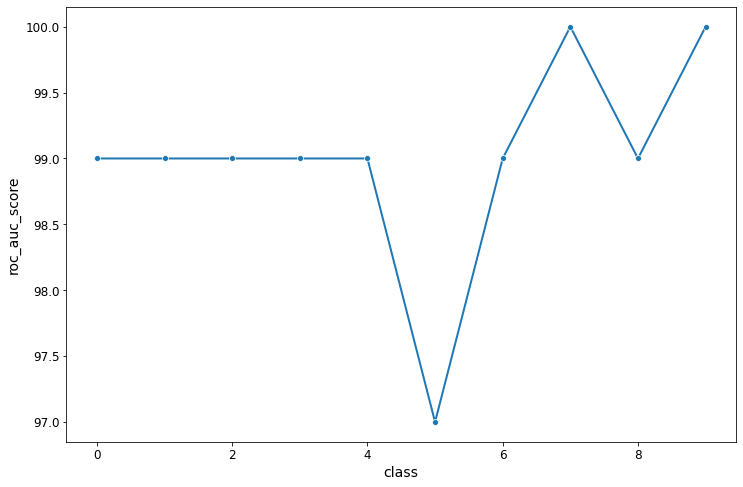

In [111]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(12,8))
_data = df_seq_cr[df_seq_cr.roc_auc_score!='']
_data.loc[:,'roc_auc_score'] = _data.loc[:,'roc_auc_score'].apply(lambda x:x*100).astype(int)
_data = _data.reset_index()
_data.rename(columns={'index':'class'}, inplace=True)
palette = sns.color_palette("bright", 10)
ax = sns.lineplot(data=_data, x="class", y="roc_auc_score",  marker='o', palette='tab10', linewidth='2')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Confusion Matrix

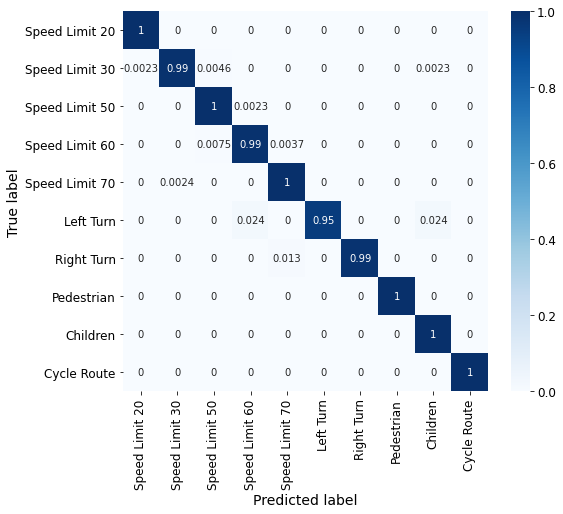

In [112]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_class).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=5)
con_mat_df = pd.DataFrame(con_mat_norm,index = class_names, columns = class_names)
con_mat_df
figure = plt.figure(figsize=(8, 7))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### TP, TN, FP, FN

In [113]:
df_seq_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, y_pred_class))
df_seq_cm.columns=class_names
df_seq_cm.index = class_names
df_seq_cm

,Speed Limit 20,Speed Limit 30,Speed Limit 50,Speed Limit 60,Speed Limit 70,Left Turn,Right Turn,Pedestrian,Children,Cycle Route
Speed Limit 20,41,0,0,0,0,0,0,0,0,0
Speed Limit 30,1,433,2,0,0,0,0,0,1,0
Speed Limit 50,0,0,441,1,0,0,0,0,0,0
Speed Limit 60,0,0,2,264,1,0,0,0,0,0
Speed Limit 70,0,1,0,0,419,0,0,0,0,0
Left Turn,0,0,0,1,0,40,0,0,1,0
Right Turn,0,0,0,0,1,0,74,0,0,0
Pedestrian,0,0,0,0,0,0,0,50,0,0
Children,0,0,0,0,0,0,0,0,109,0
Cycle Route,0,0,0,0,0,0,0,0,0,55


<AxesSubplot:title={'center':'Confusion Matrix (TP, TN, FP, FN)'}>

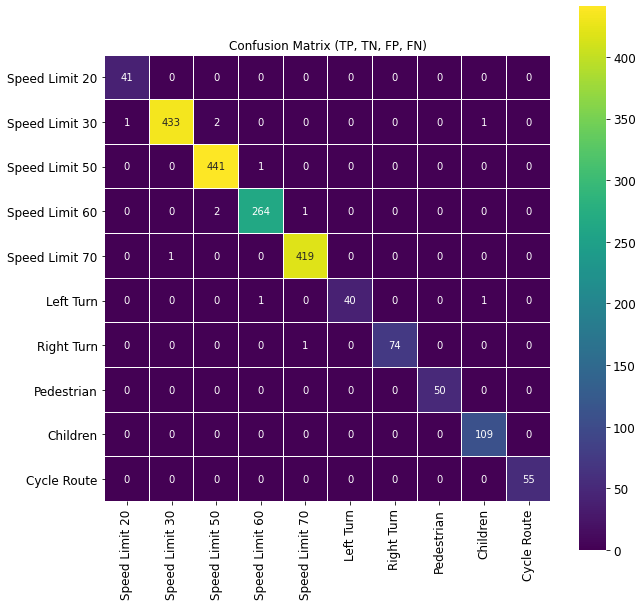

In [114]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Confusion Matrix (TP, TN, FP, FN)')
sns.heatmap(df_seq_cm, 
            cmap="viridis",
            fmt=".0f",
            annot_kws={"fontsize":10},
            square=True,
            annot=True,
           linewidths=.01,
           ax=ax)

### Grid Search

In [160]:
model = KerasClassifier(build_fn=f_CNNModelGridSearch, verbose=1)
optimizers = ['adam']
# init = ['glorot_uniform', 'normal', 'uniform']
init = ['glorot_uniform']
epochs = ar_of_epochs
param_grid = dict(optimizer=optimizers, epochs=epochs, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    verbose=1,
                    return_train_score=True,
                    n_jobs=1)

In [161]:
grid_result = grid.fit(XX, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


243/243 [==============================] - 2s 7ms/step - loss: 0.4876 - accuracy: 0.8781
Epoch 1/10
243/243 [==============================] - 7s 29ms/step - loss: 1.1909 - accuracy: 0.5632
Epoch 2/10
243/243 [==============================] - 7s 28ms/step - loss: 0.2351 - accuracy: 0.9376
Epoch 3/10
243/243 [==============================] - 7s 30ms/step - loss: 0.0934 - accuracy: 0.9787
Epoch 4/10
243/243 [==============================] - 7s 28ms/step - loss: 0.0549 - accuracy: 0.9872
Epoch 5/10
243/243 [==============================] - 7s 29ms/step - loss: 0.0340 - accuracy: 0.9930
Epoch 6/10
243/243 [==============================] - 7s 29ms/step - loss: 0.0306 - accuracy: 0.9933
Epoch 7/10
243/243 [==============================] - 7s 28ms/step - loss: 0.0217 - accuracy: 0.9950
Epoch 8/10
243/243 [==============================] - 7s 29ms/step - loss: 0.0084 - accuracy: 0.9987
Epoch 9/10
243/243 [==============================] - 7s 28ms/step - loss: 0.0265 - accuracy: 0.9930
Ep

Epoch 10/20
243/243 [==============================] - 7s 29ms/step - loss: 0.0060 - accuracy: 0.9997
Epoch 11/20
243/243 [==============================] - 7s 30ms/step - loss: 0.0098 - accuracy: 0.9978
Epoch 12/20
243/243 [==============================] - 7s 28ms/step - loss: 0.0045 - accuracy: 0.9994
Epoch 13/20
243/243 [==============================] - 7s 30ms/step - loss: 0.0028 - accuracy: 0.9997
Epoch 14/20
243/243 [==============================] - 7s 28ms/step - loss: 0.0132 - accuracy: 0.9964
Epoch 15/20
243/243 [==============================] - 7s 30ms/step - loss: 0.0232 - accuracy: 0.9938
Epoch 16/20
243/243 [==============================] - 7s 28ms/step - loss: 0.0126 - accuracy: 0.9959
Epoch 17/20
243/243 [==============================] - 7s 30ms/step - loss: 0.0045 - accuracy: 0.9988
Epoch 18/20
243/243 [==============================] - 7s 30ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 19/20
243/243 [==============================] - 7s 30ms/step - loss: 5.2118

243/243 [==============================] - 7s 31ms/step - loss: 1.6462e-04 - accuracy: 1.0000
Epoch 26/30
243/243 [==============================] - 7s 30ms/step - loss: 1.5565e-04 - accuracy: 1.0000
Epoch 27/30
243/243 [==============================] - 8s 34ms/step - loss: 1.2433e-04 - accuracy: 1.0000
Epoch 28/30
243/243 [==============================] - 8s 33ms/step - loss: 1.0812e-04 - accuracy: 1.0000
Epoch 29/30
243/243 [==============================] - 8s 33ms/step - loss: 1.0440e-04 - accuracy: 1.0000
Epoch 30/30
243/243 [==============================] - 2s 8ms/step - loss: 7.3458e-05 - accuracy: 1.0000
Epoch 1/30
243/243 [==============================] - 8s 33ms/step - loss: 1.3662 - accuracy: 0.5151
Epoch 2/30
243/243 [==============================] - 8s 34ms/step - loss: 0.3308 - accuracy: 0.9007
Epoch 3/30
243/243 [==============================] - 8s 35ms/step - loss: 0.1281 - accuracy: 0.9649
Epoch 4/30
243/243 [==============================] - 8s 31ms/step - loss:

243/243 [==============================] - 7s 27ms/step - loss: 0.0070 - accuracy: 0.9990
Epoch 13/40
243/243 [==============================] - 7s 29ms/step - loss: 0.0027 - accuracy: 0.9999
Epoch 14/40
243/243 [==============================] - 7s 29ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 15/40
243/243 [==============================] - 7s 29ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 16/40
243/243 [==============================] - 7s 30ms/step - loss: 8.6961e-04 - accuracy: 1.0000
Epoch 17/40
243/243 [==============================] - 7s 28ms/step - loss: 7.4083e-04 - accuracy: 1.0000 0s - loss: 7.0627e-0
Epoch 18/40
243/243 [==============================] - 7s 30ms/step - loss: 0.0048 - accuracy: 0.9992
Epoch 19/40
243/243 [==============================] - 7s 28ms/step - loss: 0.0422 - accuracy: 0.9896
Epoch 20/40
243/243 [==============================] - 7s 28ms/step - loss: 0.0035 - accuracy: 0.9995
Epoch 21/40
243/243 [==============================] - 7s 28ms/st

243/243 [==============================] - 2s 8ms/step - loss: 4.0021e-04 - accuracy: 1.0000
Epoch 1/50
243/243 [==============================] - 7s 29ms/step - loss: 1.3040 - accuracy: 0.5285
Epoch 2/50
243/243 [==============================] - 9s 35ms/step - loss: 0.2565 - accuracy: 0.9291
Epoch 3/50
243/243 [==============================] - 10s 39ms/step - loss: 0.1162 - accuracy: 0.9698
Epoch 4/50
243/243 [==============================] - 8s 33ms/step - loss: 0.0612 - accuracy: 0.9867
Epoch 5/50
243/243 [==============================] - 8s 32ms/step - loss: 0.0416 - accuracy: 0.9912
Epoch 6/50
243/243 [==============================] - 8s 32ms/step - loss: 0.0366 - accuracy: 0.9910
Epoch 7/50
243/243 [==============================] - 8s 33ms/step - loss: 0.0208 - accuracy: 0.9948
Epoch 8/50
243/243 [==============================] - 8s 33ms/step - loss: 0.0192 - accuracy: 0.9960
Epoch 9/50
243/243 [==============================] - 8s 33ms/step - loss: 0.0143 - accuracy: 0.99

243/243 [==============================] - 7s 31ms/step - loss: 6.0639e-04 - accuracy: 1.0000
Epoch 26/50
243/243 [==============================] - 8s 32ms/step - loss: 5.2961e-04 - accuracy: 1.0000
Epoch 27/50
243/243 [==============================] - 8s 31ms/step - loss: 4.1672e-04 - accuracy: 1.0000
Epoch 28/50
243/243 [==============================] - 7s 29ms/step - loss: 3.6364e-04 - accuracy: 1.0000
Epoch 29/50
243/243 [==============================] - 7s 30ms/step - loss: 3.3095e-04 - accuracy: 1.0000
Epoch 30/50
243/243 [==============================] - 7s 29ms/step - loss: 0.0251 - accuracy: 0.9936
Epoch 31/50
243/243 [==============================] - 8s 32ms/step - loss: 0.0301 - accuracy: 0.9916
Epoch 32/50
243/243 [==============================] - 7s 28ms/step - loss: 0.0053 - accuracy: 0.9986
Epoch 33/50
243/243 [==============================] - 7s 28ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 34/50
243/243 [==============================] - 7s 29ms/step - loss

243/243 [==============================] - 8s 34ms/step - loss: 1.8365e-04 - accuracy: 1.0000
Epoch 26/50
243/243 [==============================] - 8s 31ms/step - loss: 1.6148e-04 - accuracy: 1.0000
Epoch 27/50
243/243 [==============================] - 8s 31ms/step - loss: 1.3953e-04 - accuracy: 1.0000
Epoch 28/50
243/243 [==============================] - 8s 31ms/step - loss: 1.2333e-04 - accuracy: 1.0000 0s - loss: 1.2
Epoch 29/50
243/243 [==============================] - 8s 32ms/step - loss: 9.7251e-05 - accuracy: 1.0000
Epoch 30/50
243/243 [==============================] - 7s 29ms/step - loss: 8.9625e-05 - accuracy: 1.0000
Epoch 31/50
243/243 [==============================] - 7s 30ms/step - loss: 7.3569e-05 - accuracy: 1.0000
Epoch 32/50
243/243 [==============================] - 7s 29ms/step - loss: 6.8465e-05 - accuracy: 1.0000
Epoch 33/50
243/243 [==============================] - 7s 30ms/step - loss: 5.8723e-05 - accuracy: 1.0000
Epoch 34/50
243/243 [======================

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 94.6min finished


Epoch 1/30
303/303 [==============================] - 9s 29ms/step - loss: 1.1448 - accuracy: 0.5854
Epoch 2/30
303/303 [==============================] - 9s 30ms/step - loss: 0.2222 - accuracy: 0.9418
Epoch 3/30
303/303 [==============================] - 9s 29ms/step - loss: 0.1026 - accuracy: 0.9755
Epoch 4/30
303/303 [==============================] - 9s 30ms/step - loss: 0.0673 - accuracy: 0.9838
Epoch 5/30
303/303 [==============================] - 9s 29ms/step - loss: 0.0529 - accuracy: 0.9863
Epoch 6/30
303/303 [==============================] - 9s 31ms/step - loss: 0.0415 - accuracy: 0.9888
Epoch 7/30
303/303 [==============================] - 9s 29ms/step - loss: 0.0236 - accuracy: 0.9941
Epoch 8/30
303/303 [==============================] - 9s 29ms/step - loss: 0.0202 - accuracy: 0.9955
Epoch 9/30
303/303 [==============================] - 9s 30ms/step - loss: 0.0132 - accuracy: 0.9968
Epoch 10/30
303/303 [==============================] - 9s 29ms/step - loss: 0.0209 - accura

In [162]:
gr_results = grid_result.cv_results_

In [163]:
scores_df = pd.DataFrame(gr_results).sort_values(by=['param_epochs','param_init'])
scores_df = scores_df.drop(['params'], axis=1)
scores_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_init,param_optimizer,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,8.045957,0.283659,0.717080,0.060881,1,glorot_uniform,adam,0.065531,0.281734,0.376677,0.168215,0.146027,0.207637,0.109187,6,0.837977,0.783411,0.836300,0.866357,0.878096,0.840428,0.032757
1,73.344321,1.745637,0.638580,0.029669,10,glorot_uniform,adam,0.783798,0.907121,0.911765,0.727038,0.160991,0.698142,0.277853,5,0.999742,0.998839,0.998194,0.998839,0.996001,0.998323,0.001261
2,146.236983,3.244253,0.698502,0.128409,20,glorot_uniform,adam,0.833333,0.897317,0.886997,0.714138,0.163055,0.698968,0.275748,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,221.907430,6.343527,0.824745,0.208375,30,glorot_uniform,adam,0.865841,0.895253,0.913313,0.828689,0.162539,0.733127,0.286729,1,1.000000,1.000000,1.000000,1.000000,0.999355,0.999871,0.000258
4,291.098924,3.476084,0.731346,0.160124,40,glorot_uniform,adam,0.813209,0.895769,0.938080,0.760062,0.163571,0.714138,0.282202,3,1.000000,0.999871,1.000000,1.000000,1.000000,0.999974,0.000052
5,378.245308,19.634999,0.875311,0.195833,50,glorot_uniform,adam,0.856037,0.895253,0.931373,0.780186,0.163055,0.725181,0.285508,2,1.000000,1.000000,1.000000,1.000000,0.999871,0.999974,0.000052


In [164]:
scores_df_gp = scores_df.groupby(['param_epochs'], as_index=False).agg({'mean_test_score':'sum','mean_train_score':'sum'})
scores_df_gp

,param_epochs,mean_test_score,mean_train_score
0,1,0.207637,0.840428
1,10,0.698142,0.998323
2,20,0.698968,1.000000
3,30,0.733127,0.999871
4,40,0.714138,0.999974
5,50,0.725181,0.999974


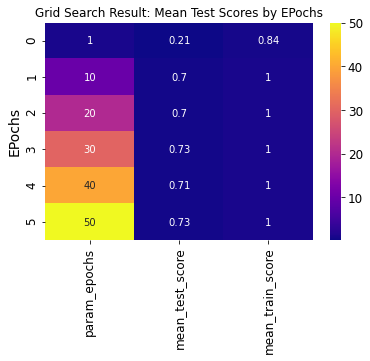

In [165]:
sns.heatmap(scores_df_gp, annot=True, cmap='plasma')
plt.title('Grid Search Result: Mean Test Scores by EPochs');
plt.ylabel('EPochs');

## Question No. 4

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.60, random_state=no_of_seeds)
print('X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)
X_train = X_train.to_numpy().reshape(X_train.shape[0],_image_resize,_image_resize,1)
X_test = X_test.to_numpy().reshape(X_test.shape[0],_image_resize,_image_resize,1)
print('X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)

X_train (3876, 784) X_test (5814, 784) y_train (3876, 1) y_test (5814, 1)
X_train (3876, 28, 28, 1) X_test (5814, 28, 28, 1) y_train (3876, 1) y_test (5814, 1)


### Model Evaluation

In [167]:
if os.path.exists("logs/fit/seq/") : shutil.rmtree("logs/fit/seq/")
_model_cnn = f_createCNNModel()
_model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = _model_cnn.fit(X_train, y_train, epochs=no_of_epochs, validation_data=(X_test, y_test))

log_dir = "logs/fit/seq/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es_callback = EarlyStopping(monitor='loss', patience=3) # This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs
_model_cnn.fit(x=X_train, 
              y=y_train, 
              epochs=no_of_epochs, 
              verbose=1, # Suppress chatty output
              callbacks=[tensorboard_callback,es_callback],
              validation_data=(X_test, y_test),
             )
test_loss, test_acc = _model_cnn.evaluate(X_test,  y_test, verbose=0)
print('\nTest accuracy:', test_acc)
# %reload_ext tensorboard
# %tensorboard --logdir logs/fit/seq/
# Launch http://localhost:6006/

Epoch 1/30
122/122 [==============================] - 6s 48ms/step - loss: 1.7862 - accuracy: 0.3382 - val_loss: 1.5072 - val_accuracy: 0.4248
Epoch 2/30
122/122 [==============================] - 5s 41ms/step - loss: 1.0846 - accuracy: 0.6166 - val_loss: 0.6638 - val_accuracy: 0.7890
Epoch 3/30
122/122 [==============================] - 8s 68ms/step - loss: 0.4670 - accuracy: 0.8602 - val_loss: 0.3548 - val_accuracy: 0.8954
Epoch 4/30
122/122 [==============================] - 5s 40ms/step - loss: 0.2291 - accuracy: 0.9386 - val_loss: 0.1851 - val_accuracy: 0.9486
Epoch 5/30
122/122 [==============================] - 5s 41ms/step - loss: 0.1620 - accuracy: 0.9520 - val_loss: 0.1626 - val_accuracy: 0.9556
Epoch 6/30
122/122 [==============================] - 5s 41ms/step - loss: 0.1185 - accuracy: 0.9662 - val_loss: 0.1580 - val_accuracy: 0.9506
Epoch 7/30
122/122 [==============================] - 5s 40ms/step - loss: 0.0814 - accuracy: 0.9799 - val_loss: 0.1210 - val_accuracy: 0.9678

#### Accurancy and Loss Plot

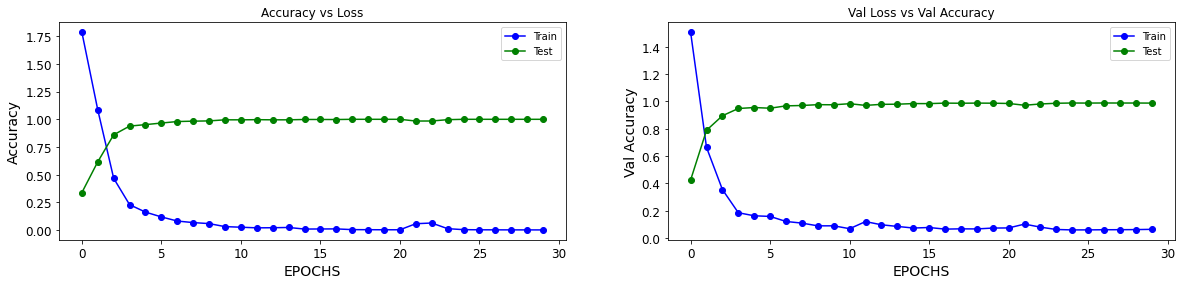

In [168]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,4))
ax1.plot(history.history['loss'], marker='o', label='Train', color='b')
ax1.plot(history.history['accuracy'], marker='o', label='Test', color='g')
ax1.set_title('Accuracy vs Loss')
ax1.set(xlabel='EPOCHS', ylabel='Accuracy')
ax1.legend(loc='upper right')
ax2.plot(history.history['val_loss'], marker='o', label='Train', color='b')
ax2.plot(history.history['val_accuracy'], marker='o', label='Test', color='g')
ax2.set_title('Val Loss vs Val Accuracy')
ax2.set(xlabel='EPOCHS', ylabel='Val Accuracy')
ax2.legend(loc='upper right')

### Predictions

In [169]:
y_predict = _model_cnn.predict(X_test)
y_pred_class = np.argmax(_model_cnn.predict(X_test), axis=-1) #predict_classes is depereciated

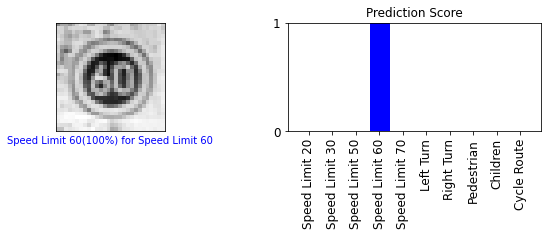

In [170]:
record_pred=15
f_PlotPresentPredictions(record_pred, y_predict[record_pred], y_test, X_test)

### Classification Report

In [171]:
roc_auc_score = f_ROC_AUC_Score_Multiclass(y_test.to_numpy().ravel(),y_pred_class)

In [172]:
roc_auc_score['accuracy']=''
roc_auc_score['macro avg']=''
roc_auc_score['weighted avg']=''
np_roc = []
for key, value in roc_auc_score.items():
    np_roc.append(value)

In [173]:
_classification_report = sklearn.metrics.classification_report(y_test, y_pred_class, output_dict=True)
df_seq_cr = pd.DataFrame(_classification_report).transpose()
df_seq_cr.loc['accuracy','precision']=''
df_seq_cr.loc['accuracy','recall']=''
df_seq_cr['roc_auc_score'] = np_roc
df_seq_cr

,precision,recall,f1-score,support,roc_auc_score
0,1,0.919355,0.957983,124.000000,0.959677
1,0.978328,0.991373,0.984807,1275.000000,0.992602
2,0.988506,0.992785,0.990641,1386.000000,0.994586
3,0.991617,0.986889,0.989247,839.000000,0.992741
4,0.995033,0.992568,0.993799,1211.000000,0.995632
5,1,0.97479,0.987234,119.000000,0.987395
6,0.995261,0.981308,0.988235,214.000000,0.990565
7,0.993151,0.935484,0.963455,155.000000,0.967654
8,0.984663,0.975684,0.980153,329.000000,0.987386
9,0.91954,0.987654,0.952381,162.000000,0.992589


In [174]:
df_seq_cr.reset_index(inplace=True)
df_seq_cr = df_seq_cr.rename(columns = {'index':'Measure','f1-score':'f1_score'})
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='0', class_names[0], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='1', class_names[1], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='2', class_names[2], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='3', class_names[3], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='4', class_names[4], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='5', class_names[5], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='6', class_names[6], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='7', class_names[7], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='8', class_names[8], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='9', class_names[9], df_seq_cr['Measure'])
df_seq_cr

,Measure,precision,recall,f1_score,support,roc_auc_score
0,Speed Limit 20,1,0.919355,0.957983,124.000000,0.959677
1,Speed Limit 30,0.978328,0.991373,0.984807,1275.000000,0.992602
2,Speed Limit 50,0.988506,0.992785,0.990641,1386.000000,0.994586
3,Speed Limit 60,0.991617,0.986889,0.989247,839.000000,0.992741
4,Speed Limit 70,0.995033,0.992568,0.993799,1211.000000,0.995632
5,Left Turn,1,0.97479,0.987234,119.000000,0.987395
6,Right Turn,0.995261,0.981308,0.988235,214.000000,0.990565
7,Pedestrian,0.993151,0.935484,0.963455,155.000000,0.967654
8,Children,0.984663,0.975684,0.980153,329.000000,0.987386
9,Cycle Route,0.91954,0.987654,0.952381,162.000000,0.992589


### ROC AUC Score Plot

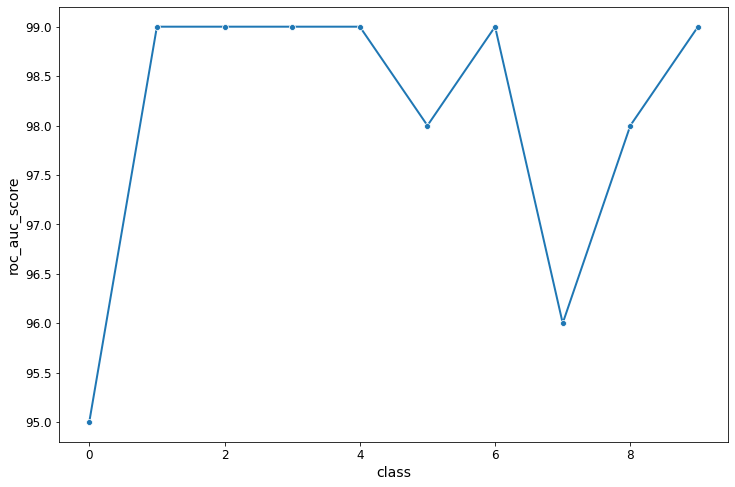

In [175]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(12,8))
_data = df_seq_cr[df_seq_cr.roc_auc_score!='']
_data.loc[:,'roc_auc_score'] = _data.loc[:,'roc_auc_score'].apply(lambda x:x*100).astype(int)
_data = _data.reset_index()
_data.rename(columns={'index':'class'}, inplace=True)
palette = sns.color_palette("bright", 10)
ax = sns.lineplot(data=_data, x="class", y="roc_auc_score",  marker='o', palette='tab10', linewidth='2')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Confusion Matrix

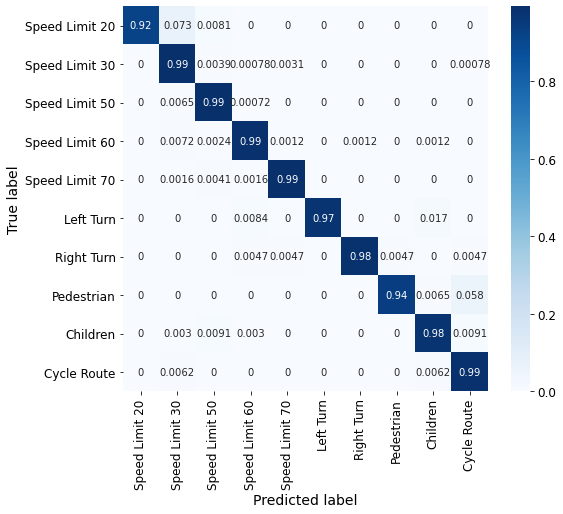

In [176]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_class).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=5)
con_mat_df = pd.DataFrame(con_mat_norm,index = class_names, columns = class_names)
con_mat_df
figure = plt.figure(figsize=(8, 7))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### TP, TN, FP, FN

In [177]:
df_seq_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, y_pred_class))
df_seq_cm.columns=class_names
df_seq_cm.index = class_names
df_seq_cm

,Speed Limit 20,Speed Limit 30,Speed Limit 50,Speed Limit 60,Speed Limit 70,Left Turn,Right Turn,Pedestrian,Children,Cycle Route
Speed Limit 20,114,9,1,0,0,0,0,0,0,0
Speed Limit 30,0,1264,5,1,4,0,0,0,0,1
Speed Limit 50,0,9,1376,1,0,0,0,0,0,0
Speed Limit 60,0,6,2,828,1,0,1,0,1,0
Speed Limit 70,0,2,5,2,1202,0,0,0,0,0
Left Turn,0,0,0,1,0,116,0,0,2,0
Right Turn,0,0,0,1,1,0,210,1,0,1
Pedestrian,0,0,0,0,0,0,0,145,1,9
Children,0,1,3,1,0,0,0,0,321,3
Cycle Route,0,1,0,0,0,0,0,0,1,160


<AxesSubplot:title={'center':'Confusion Matrix (TP, TN, FP, FN)'}>

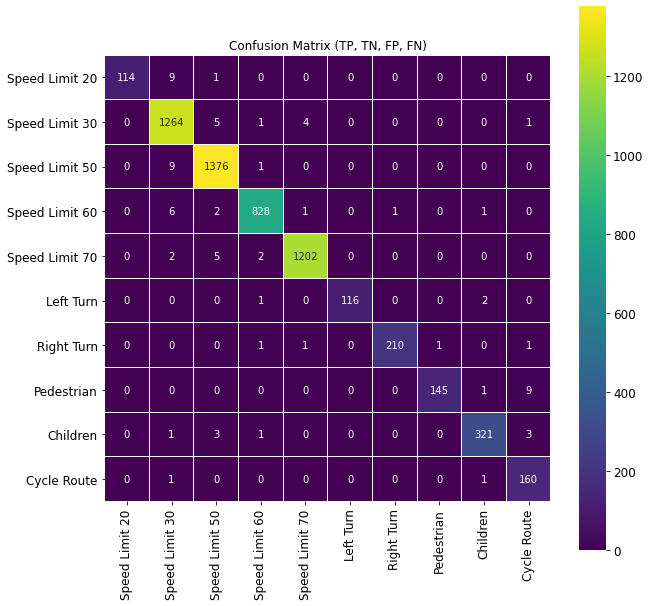

In [178]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Confusion Matrix (TP, TN, FP, FN)')
sns.heatmap(df_seq_cm, 
            cmap="viridis",
            fmt=".0f",
            annot_kws={"fontsize":10},
            square=True,
            annot=True,
           linewidths=.01,
           ax=ax)

### Grid Search

In [179]:
model = KerasClassifier(build_fn=f_CNNModelGridSearch, verbose=1)
optimizers = ['adam']
# init = ['glorot_uniform', 'normal', 'uniform']
init = ['glorot_uniform']
epochs = ar_of_epochs
param_grid = dict(optimizer=optimizers, epochs=epochs, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    verbose=1,
                    return_train_score=True,
                    n_jobs=2)

In [180]:
grid_result = grid.fit(XX, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 81.4min finished


Epoch 1/50
303/303 [==============================] - 9s 30ms/step - loss: 1.1904 - accuracy: 0.5672
Epoch 2/50
303/303 [==============================] - 9s 30ms/step - loss: 0.2169 - accuracy: 0.9390
Epoch 3/50
303/303 [==============================] - 9s 29ms/step - loss: 0.0974 - accuracy: 0.9760
Epoch 4/50
303/303 [==============================] - 9s 29ms/step - loss: 0.0593 - accuracy: 0.9843
Epoch 5/50
303/303 [==============================] - 9s 29ms/step - loss: 0.0432 - accuracy: 0.9892
Epoch 6/50
303/303 [==============================] - 9s 28ms/step - loss: 0.0332 - accuracy: 0.9907
Epoch 7/50
303/303 [==============================] - 9s 29ms/step - loss: 0.0255 - accuracy: 0.9940
Epoch 8/50
303/303 [==============================] - 9s 30ms/step - loss: 0.0158 - accuracy: 0.9965
Epoch 9/50
303/303 [==============================] - 9s 30ms/step - loss: 0.0192 - accuracy: 0.9946
Epoch 10/50
303/303 [==============================] - 9s 29ms/step - loss: 0.0163 - accura

In [181]:
gr_results = grid_result.cv_results_

In [182]:
scores_df = pd.DataFrame(gr_results).sort_values(by=['param_epochs','param_init'])
scores_df = scores_df.drop(['params'], axis=1)
scores_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_init,param_optimizer,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,13.468351,0.277152,1.393397,0.559554,1,glorot_uniform,adam,0.129515,0.765738,0.361197,0.487616,0.058824,0.360578,0.254849,6,0.891512,0.834365,0.778638,0.865325,0.700593,0.814087,0.068071
1,129.968181,3.740385,2.686677,0.408595,10,glorot_uniform,adam,0.753870,0.871001,0.890609,0.801858,0.162539,0.695975,0.271158,5,0.998710,0.998581,0.998839,0.999742,0.998968,0.998968,0.000408
2,259.094569,3.977586,2.275827,0.153467,20,glorot_uniform,adam,0.816821,0.891125,0.913313,0.770382,0.163055,0.710939,0.278691,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,377.114304,4.875413,2.194596,0.100490,30,glorot_uniform,adam,0.837461,0.934469,0.889061,0.773994,0.163055,0.719608,0.283365,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,499.668764,6.278125,2.187707,0.068286,40,glorot_uniform,adam,0.833333,0.880805,0.887513,0.735294,0.163571,0.700103,0.273727,4,1.000000,1.000000,1.000000,0.999355,1.000000,0.999871,0.000258
5,594.250482,55.734818,1.812997,0.640534,50,glorot_uniform,adam,0.861197,0.895253,0.940660,0.801342,0.163055,0.732301,0.288232,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [183]:
scores_df_gp = scores_df.groupby(['param_epochs'], as_index=False).agg({'mean_test_score':'sum','mean_train_score':'sum'})
scores_df_gp

,param_epochs,mean_test_score,mean_train_score
0,1,0.360578,0.814087
1,10,0.695975,0.998968
2,20,0.710939,1.000000
3,30,0.719608,1.000000
4,40,0.700103,0.999871
5,50,0.732301,1.000000


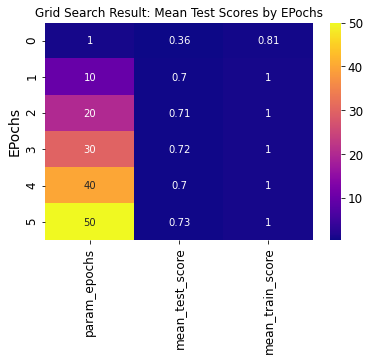

In [184]:
sns.heatmap(scores_df_gp, annot=True, cmap='plasma')
plt.title('Grid Search Result: Mean Test Scores by EPochs');
plt.ylabel('EPochs');

## Question No. 5

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.93, random_state=no_of_seeds)
print('X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)
X_train = X_train.to_numpy().reshape(X_train.shape[0],_image_resize,_image_resize,1)
X_test = X_test.to_numpy().reshape(X_test.shape[0],_image_resize,_image_resize,1)
print('X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)

X_train (678, 784) X_test (9012, 784) y_train (678, 1) y_test (9012, 1)
X_train (678, 28, 28, 1) X_test (9012, 28, 28, 1) y_train (678, 1) y_test (9012, 1)


### Model Evaluation

In [186]:
if os.path.exists("logs/fit/seq/") : shutil.rmtree("logs/fit/seq/")
_model_cnn = f_createCNNModel()
_model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = _model_cnn.fit(X_train, y_train, epochs=no_of_epochs, validation_data=(X_test, y_test))
log_dir = "logs/fit/seq/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es_callback = EarlyStopping(monitor='loss', patience=3) # This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs
_model_cnn.fit(x=X_train, 
              y=y_train, 
              epochs=no_of_epochs, 
              verbose=1, # Suppress chatty output
              callbacks=[tensorboard_callback,es_callback],
              validation_data=(X_test, y_test),
             )
test_loss, test_acc = _model_cnn.evaluate(X_test,  y_test, verbose=0)
print('\nTest accuracy:', test_acc)
# %reload_ext tensorboard
# %tensorboard --logdir logs/fit/seq/
# Launch http://localhost:6006/

Epoch 1/30
22/22 [==============================] - 4s 163ms/step - loss: 2.0415 - accuracy: 0.2271 - val_loss: 1.8995 - val_accuracy: 0.2896
Epoch 2/30
22/22 [==============================] - 3s 127ms/step - loss: 1.8983 - accuracy: 0.3186 - val_loss: 1.7586 - val_accuracy: 0.3333
Epoch 3/30
22/22 [==============================] - 3s 128ms/step - loss: 1.7734 - accuracy: 0.3112 - val_loss: 1.6739 - val_accuracy: 0.3485
Epoch 4/30
22/22 [==============================] - 3s 126ms/step - loss: 1.6695 - accuracy: 0.3525 - val_loss: 1.5525 - val_accuracy: 0.3953
Epoch 5/30
22/22 [==============================] - 3s 129ms/step - loss: 1.4964 - accuracy: 0.4631 - val_loss: 1.3926 - val_accuracy: 0.4734
Epoch 6/30
22/22 [==============================] - 3s 119ms/step - loss: 1.3471 - accuracy: 0.4705 - val_loss: 1.2233 - val_accuracy: 0.5699
Epoch 7/30
22/22 [==============================] - 3s 122ms/step - loss: 1.1215 - accuracy: 0.6121 - val_loss: 1.0293 - val_accuracy: 0.6932
Epoch 

#### Accurancy and Loss Plot

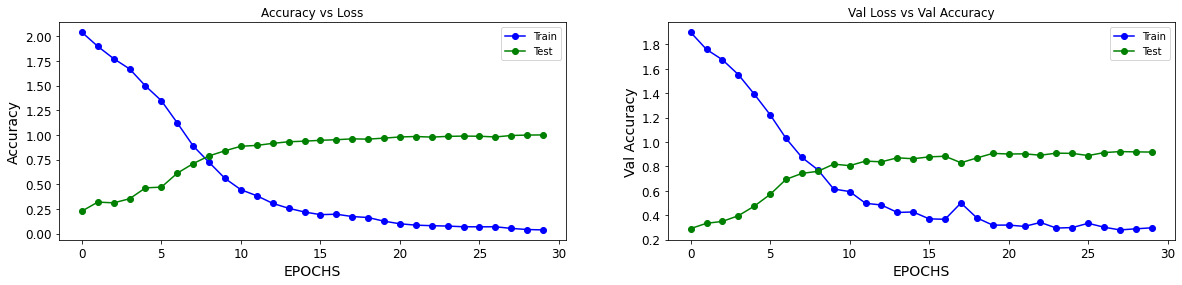

In [187]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,4))
ax1.plot(history.history['loss'], marker='o', label='Train', color='b')
ax1.plot(history.history['accuracy'], marker='o', label='Test', color='g')
ax1.set_title('Accuracy vs Loss')
ax1.set(xlabel='EPOCHS', ylabel='Accuracy')
ax1.legend(loc='upper right')
ax2.plot(history.history['val_loss'], marker='o', label='Train', color='b')
ax2.plot(history.history['val_accuracy'], marker='o', label='Test', color='g')
ax2.set_title('Val Loss vs Val Accuracy')
ax2.set(xlabel='EPOCHS', ylabel='Val Accuracy')
ax2.legend(loc='upper right')

### Predictions

In [188]:
y_predict = _model_cnn.predict(X_test)
y_pred_class = np.argmax(_model_cnn.predict(X_test), axis=-1) #predict_classes is depereciated

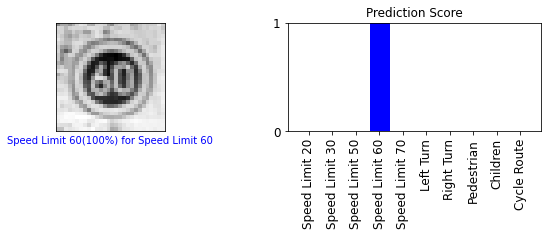

In [189]:
record_pred=15
f_PlotPresentPredictions(record_pred, y_predict[record_pred], y_test, X_test)

### Classification Report

In [190]:
roc_auc_score = f_ROC_AUC_Score_Multiclass(y_test.to_numpy().ravel(),y_pred_class)

In [191]:
roc_auc_score['accuracy']=''
roc_auc_score['macro avg']=''
roc_auc_score['weighted avg']=''
np_roc = []
for key, value in roc_auc_score.items():
    np_roc.append(value)

In [192]:
_classification_report = sklearn.metrics.classification_report(y_test, y_pred_class, output_dict=True)
df_seq_cr = pd.DataFrame(_classification_report).transpose()
df_seq_cr.loc['accuracy','precision']=''
df_seq_cr.loc['accuracy','recall']=''
df_seq_cr['roc_auc_score'] = np_roc
df_seq_cr

,precision,recall,f1-score,support,roc_auc_score
0,0.689655,0.52356,0.595238,191.00000,0.759229
1,0.879727,0.93285,0.905510,2070.00000,0.94741
2,0.966292,0.895409,0.929501,2113.00000,0.942921
3,0.918116,0.963498,0.940260,1315.00000,0.974409
4,0.943038,0.979189,0.960774,1826.00000,0.98208
5,0.99375,0.836842,0.908571,190.00000,0.918364
6,0.824658,0.898507,0.860000,335.00000,0.945566
7,0.989305,0.837104,0.906863,221.00000,0.918438
8,0.885714,0.869739,0.877654,499.00000,0.931581
9,0.834746,0.781746,0.807377,252.00000,0.888647


In [193]:
df_seq_cr.reset_index(inplace=True)
df_seq_cr = df_seq_cr.rename(columns = {'index':'Measure','f1-score':'f1_score'})
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='0', class_names[0], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='1', class_names[1], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='2', class_names[2], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='3', class_names[3], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='4', class_names[4], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='5', class_names[5], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='6', class_names[6], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='7', class_names[7], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='8', class_names[8], df_seq_cr['Measure'])
df_seq_cr['Measure'] = np.where(df_seq_cr['Measure']=='9', class_names[9], df_seq_cr['Measure'])
df_seq_cr

,Measure,precision,recall,f1_score,support,roc_auc_score
0,Speed Limit 20,0.689655,0.52356,0.595238,191.00000,0.759229
1,Speed Limit 30,0.879727,0.93285,0.905510,2070.00000,0.94741
2,Speed Limit 50,0.966292,0.895409,0.929501,2113.00000,0.942921
3,Speed Limit 60,0.918116,0.963498,0.940260,1315.00000,0.974409
4,Speed Limit 70,0.943038,0.979189,0.960774,1826.00000,0.98208
5,Left Turn,0.99375,0.836842,0.908571,190.00000,0.918364
6,Right Turn,0.824658,0.898507,0.860000,335.00000,0.945566
7,Pedestrian,0.989305,0.837104,0.906863,221.00000,0.918438
8,Children,0.885714,0.869739,0.877654,499.00000,0.931581
9,Cycle Route,0.834746,0.781746,0.807377,252.00000,0.888647


### ROC AUC Score Plot

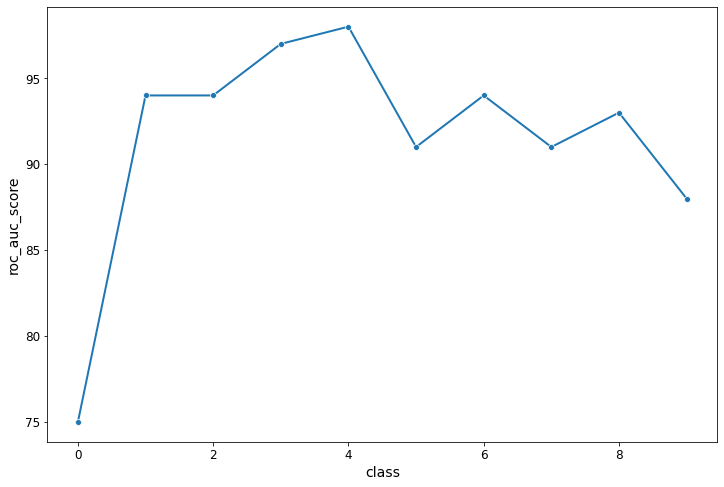

In [194]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(figsize=(12,8))
_data = df_seq_cr[df_seq_cr.roc_auc_score!='']
_data.loc[:,'roc_auc_score'] = _data.loc[:,'roc_auc_score'].apply(lambda x:x*100).astype(int)
_data = _data.reset_index()
_data.rename(columns={'index':'class'}, inplace=True)
palette = sns.color_palette("bright", 10)
ax = sns.lineplot(data=_data, x="class", y="roc_auc_score",  marker='o', palette='tab10', linewidth='2')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Confusion Matrix

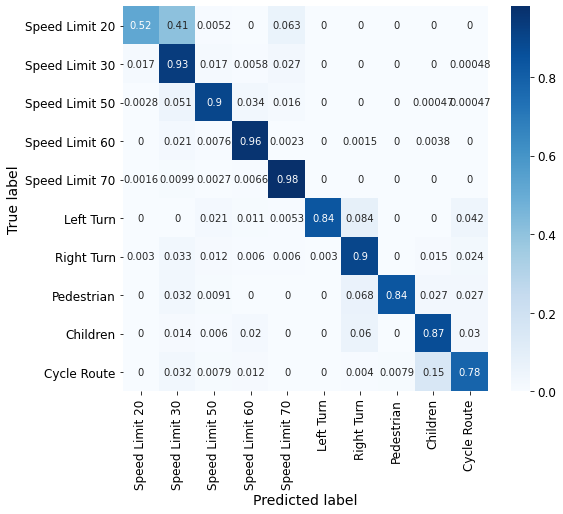

In [195]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_class).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=5)
con_mat_df = pd.DataFrame(con_mat_norm,index = class_names, columns = class_names)
con_mat_df
figure = plt.figure(figsize=(8, 7))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### TP, TN, FP, FN

In [196]:
df_seq_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, y_pred_class))
df_seq_cm.columns=class_names
df_seq_cm.index = class_names
df_seq_cm

,Speed Limit 20,Speed Limit 30,Speed Limit 50,Speed Limit 60,Speed Limit 70,Left Turn,Right Turn,Pedestrian,Children,Cycle Route
Speed Limit 20,100,78,1,0,12,0,0,0,0,0
Speed Limit 30,35,1931,35,12,56,0,0,0,0,1
Speed Limit 50,6,107,1892,72,34,0,0,0,1,1
Speed Limit 60,0,28,10,1267,3,0,2,0,5,0
Speed Limit 70,3,18,5,12,1788,0,0,0,0,0
Left Turn,0,0,4,2,1,159,16,0,0,8
Right Turn,1,11,4,2,2,1,301,0,5,8
Pedestrian,0,7,2,0,0,0,15,185,6,6
Children,0,7,3,10,0,0,30,0,434,15
Cycle Route,0,8,2,3,0,0,1,2,39,197


<AxesSubplot:title={'center':'Confusion Matrix (TP, TN, FP, FN)'}>

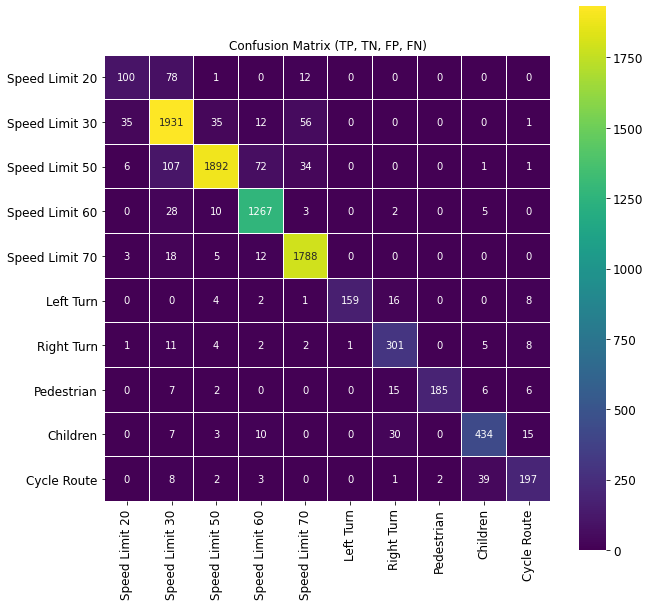

In [197]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Confusion Matrix (TP, TN, FP, FN)')
sns.heatmap(df_seq_cm, 
            cmap="viridis",
            fmt=".0f",
            annot_kws={"fontsize":10},
            square=True,
            annot=True,
           linewidths=.01,
           ax=ax)

### Grid Search

In [198]:
model = KerasClassifier(build_fn=f_CNNModelGridSearch, verbose=1)
optimizers = ['adam']
# init = ['glorot_uniform', 'normal', 'uniform']
init = ['glorot_uniform']
epochs = ar_of_epochs
param_grid = dict(optimizer=optimizers, epochs=epochs, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    verbose=1,
                    return_train_score=True,
                    n_jobs=2)

In [199]:
grid_result = grid.fit(XX, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 81.1min finished


Epoch 1/40
303/303 [==============================] - 11s 35ms/step - loss: 1.3377 - accuracy: 0.5029
Epoch 2/40
303/303 [==============================] - 11s 35ms/step - loss: 0.2850 - accuracy: 0.9208
Epoch 3/40
303/303 [==============================] - 11s 35ms/step - loss: 0.1062 - accuracy: 0.9728
Epoch 4/40
303/303 [==============================] - 11s 36ms/step - loss: 0.0713 - accuracy: 0.9829
Epoch 5/40
303/303 [==============================] - 10s 34ms/step - loss: 0.0438 - accuracy: 0.9897
Epoch 6/40
303/303 [==============================] - 11s 35ms/step - loss: 0.0359 - accuracy: 0.9907
Epoch 7/40
303/303 [==============================] - 11s 36ms/step - loss: 0.0263 - accuracy: 0.9938
Epoch 8/40
303/303 [==============================] - 11s 35ms/step - loss: 0.0194 - accuracy: 0.9955
Epoch 9/40
303/303 [==============================] - 11s 35ms/step - loss: 0.0101 - accuracy: 0.9981
Epoch 10/40
303/303 [==============================] - 10s 34ms/step - loss: 0.020

In [200]:
gr_results = grid_result.cv_results_

In [201]:
scores_df = pd.DataFrame(gr_results).sort_values(by=['param_epochs','param_init'])
scores_df = scores_df.drop(['params'], axis=1)
scores_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,param_init,param_optimizer,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,12.865445,0.338247,1.353878,0.344840,1,glorot_uniform,adam,0.206398,0.522704,0.347781,0.141383,0.143447,0.272343,0.145935,6,0.809598,0.817208,0.825077,0.806502,0.817079,0.815093,0.006513
1,122.739696,4.831710,2.584316,0.345454,10,glorot_uniform,adam,0.729618,0.800826,0.914345,0.797214,0.162539,0.680908,0.265887,5,0.997936,0.992905,1.000000,0.997678,0.992905,0.996285,0.002875
2,252.160757,2.364499,2.232603,0.137669,20,glorot_uniform,adam,0.815789,0.888545,0.904025,0.751806,0.162023,0.704438,0.276618,4,1.000000,1.000000,1.000000,0.996001,1.000000,0.999200,0.001600
3,374.878677,5.277748,2.167198,0.093693,30,glorot_uniform,adam,0.834365,0.884933,0.897317,0.815273,0.163055,0.718989,0.279637,3,1.000000,1.000000,1.000000,1.000000,0.999613,0.999923,0.000155
4,499.513956,6.197408,2.227203,0.072483,40,glorot_uniform,adam,0.874097,0.903509,0.926213,0.776574,0.163055,0.728689,0.287387,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,599.176191,55.962110,1.807721,0.542892,50,glorot_uniform,adam,0.861713,0.915893,0.878225,0.805986,0.162023,0.724768,0.283588,2,1.000000,1.000000,1.000000,1.000000,0.994453,0.998891,0.002219


In [202]:
scores_df_gp = scores_df.groupby(['param_epochs'], as_index=False).agg({'mean_test_score':'sum','mean_train_score':'sum'})
scores_df_gp

,param_epochs,mean_test_score,mean_train_score
0,1,0.272343,0.815093
1,10,0.680908,0.996285
2,20,0.704438,0.999200
3,30,0.718989,0.999923
4,40,0.728689,1.000000
5,50,0.724768,0.998891


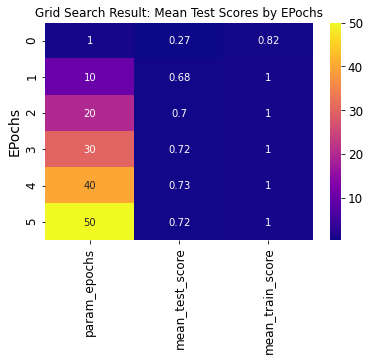

In [203]:
sns.heatmap(scores_df_gp, annot=True, cmap='plasma')
plt.title('Grid Search Result: Mean Test Scores by EPochs');
plt.ylabel('EPochs');

In [204]:
# y_pred_class = np.argmax(_model_cnn.predict(X_test), axis=-1)
print(X_test[0])

[[[0.4308696 ]
  [0.4285685 ]
  [0.30906868]
  [0.27794433]
  [0.32260752]
  [0.37564877]
  [0.315723  ]
  [0.2930166 ]
  [0.23885715]
  [0.3250637 ]
  [0.2854901 ]
  [0.3532251 ]
  [0.5253548 ]
  [0.91530615]
  [0.66026086]
  [0.52842855]
  [0.3847959 ]
  [0.40771428]
  [0.37131473]
  [0.48934695]
  [0.5243345 ]
  [0.4660204 ]
  [0.42146087]
  [0.37509942]
  [0.44632122]
  [0.58301514]
  [0.44388503]
  [0.85491836]]

 [[0.42122298]
  [0.4303343 ]
  [0.39389116]
  [0.32052565]
  [0.26238966]
  [0.28746888]
  [0.28286123]
  [0.2758312 ]
  [0.2455267 ]
  [0.25361446]
  [0.2639442 ]
  [0.27235466]
  [0.36913067]
  [0.37511957]
  [0.34434116]
  [0.310603  ]
  [0.4190204 ]
  [0.29139832]
  [0.32287756]
  [0.4734898 ]
  [0.3323493 ]
  [0.53099906]
  [0.35991538]
  [0.5335945 ]
  [0.4035138 ]
  [0.479338  ]
  [0.50147486]
  [0.5364629 ]]

 [[0.39686057]
  [0.4251565 ]
  [0.40565136]
  [0.31136784]
  [0.27533543]
  [0.35663423]
  [0.42730176]
  [0.3721858 ]
  [0.26105008]
  [0.24451864]
  [0.2